# Exploring Tools for Interpretable Machine Learning

In this notebook we want to test various ways of getting a better understanding on how non-trivial machine learning models generate predictions and how features interact with each other. This is in general not straight forward and key components are (1) understanding on the input data and (2) domain knowledge on the problem. Two great references on the subject are:

- [Interpretable Machine Learning, A Guide for Making Black Box Models Explainable by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/)
- [Interpretable Machine Learning with Python by Serg Masís](https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python)

Note that the methods discussed in this notebook are not related with *causality*. I strongly recommend to refer to the article [Be Careful When Interpreting Predictive Models in Search of Causal Insights](https://towardsdatascience.com/be-careful-when-interpreting-predictive-models-in-search-of-causal-insights-e68626e664b6) by [Scott Lundberg](https://scottlundberg.com/) (one of the core developers of [SHAP](https://shap.readthedocs.io/en/latest/index.html)). The following are two references I have found particularly useful as an introduction to *causal inference*:

- [Statistical Rethinking, A Bayesian Course with Examples in R and Stan](https://xcelab.net/rm/statistical-rethinking/) by [Richard McElreath](https://xcelab.net/rm/).
- [Causal Inference: The Mixtape](https://mixtape.scunning.com/index.html) by [Scott Cunningham](https://www.scunning.com/).

## Data

We are going to use the processed *Bike Sharing Dataset Data Set* described in [Section 3.1](https://christophm.github.io/interpretable-ml-book/bike-data.html) in [Interpretable Machine Learning, A Guide for Making Black Box Models Explainable by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/). The prediction task is to predict daily counts of rented bicycles as a function of time and other external regressors like temperature and humidity. Note that the raw data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The preprocessing steps are described [here](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R).

**Remark:** This is an updated version of the initial notebook. The main changes are (1) There was a correction on the dataset (see [this PR](https://github.com/christophM/interpretable-ml-book/pull/296)) and (2) update the [scikit-learn](https://scikit-learn.org/stable/) api for version 1.0.1. Note that the overall results and conclusions were not affected much by this change.

---
# Part I: Model Development

In this first part we work on the modeling step on which we fit two machine learning models (linear and tree ensembles) for the bike daily counts prediction task.
The intention of this notebook is **not** to build the best machine learning model but have two model flavours and compare the interpretability tools and methods on both of them.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'png'

## Read Data

In [2]:
data_path = 'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

season    yr mnth     holiday weekday      workingday weathersit      temp  \
0  WINTER  2011  JAN  NO HOLIDAY     SAT  NO WORKING DAY      MISTY  8.175849   
1  WINTER  2011  JAN  NO HOLIDAY     SUN  NO WORKING DAY      MISTY  9.083466   
2  WINTER  2011  JAN  NO HOLIDAY     MON     WORKING DAY       GOOD  1.229108   
3  WINTER  2011  JAN  NO HOLIDAY     TUE     WORKING DAY       GOOD  1.400000   
4  WINTER  2011  JAN  NO HOLIDAY     WED     WORKING DAY       GOOD  2.666979   

       hum  windspeed   cnt  days_since_2011  
0  80.5833  10.749882   985                0  
1  69.6087  16.652113   801                1  
2  43.7273  16.636703  1349                2  
3  59.0435  10.739832  1562                3  
4  43.6957  12.522300  1600                4

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


Note that we do not have missing values (not representative of most real data sets). 

The prediction task is to generate a model to predict the target variable `cnt`, which represents the number of bikes will be rented. Please visit [the data description](https://christophm.github.io/interpretable-ml-book/bike-data.html) to get more information about the features. Most of them are self-explanatory. 

## EDA

The first step in any modeling task (after problem definition and data collection) is an exploratory data analysis to understand the available data. Let us start by plotting the distribution and development over time of the target variable `cnt`.

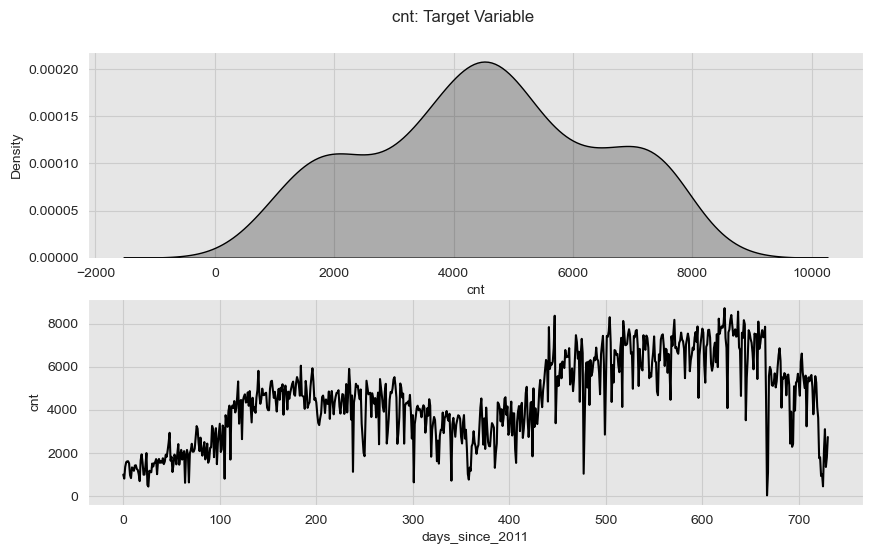

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1)
sns.kdeplot(x='cnt', data=raw_data_df, fill=True, color='black', ax=ax[0])
sns.lineplot(x='days_since_2011', y='cnt', data=raw_data_df, color='black', ax=ax[1])
fig.suptitle('cnt: Target Variable', y=0.95);

We have 2 years of data. We see a clear yearly seasonality and a slight positive trend.

- Numeric Features

Let us look into the numeric features:

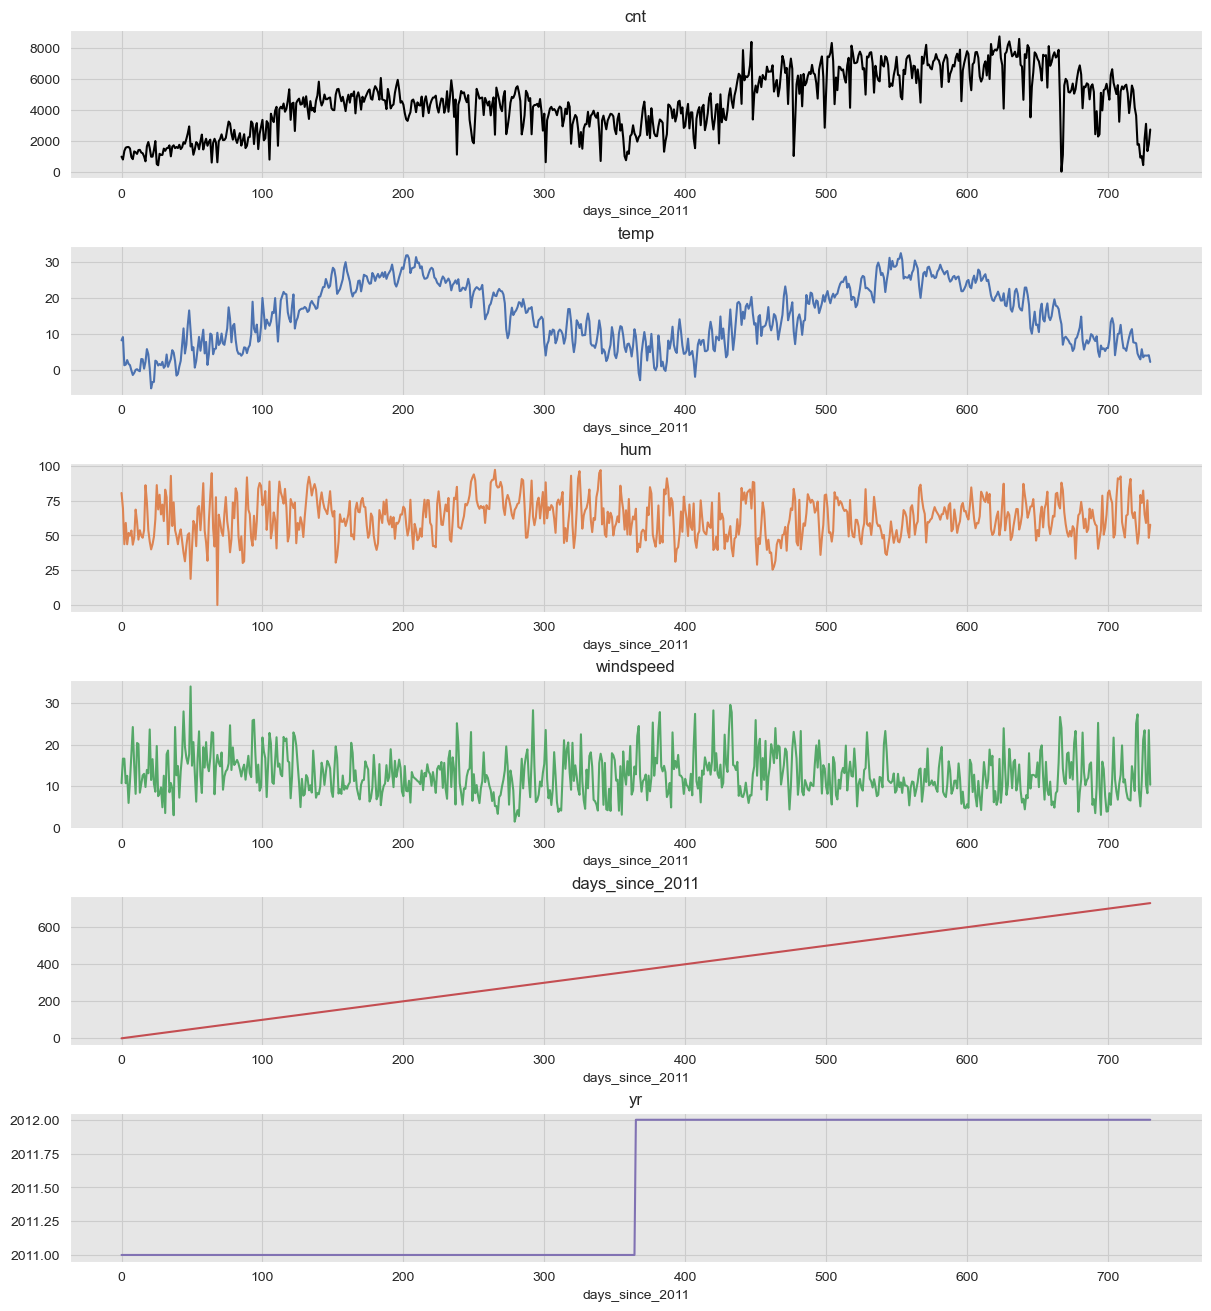

In [5]:
numeric_features = [
    'temp',
    'hum',
    'windspeed',
    'days_since_2011',
    'yr',
]

target = 'cnt'

fig, axes = plt.subplots(
    nrows=len(numeric_features) + 1,
    ncols=1,
    figsize=(12, 13),
    constrained_layout=True
)

sns.lineplot(
        x='days_since_2011',
        y=target,
        data=raw_data_df,
        color='black',
        ax=axes[0]
    )
axes[0].set(title=target, ylabel=None)

for i, feature in enumerate(numeric_features):
    ax = axes[i + 1]
    sns.lineplot(
        x='days_since_2011',
        y=feature,
        data=raw_data_df,
        color=sns_c[i],
        ax=ax
    )
    ax.set(title=feature, ylabel=None)

Let us compute the correlation:

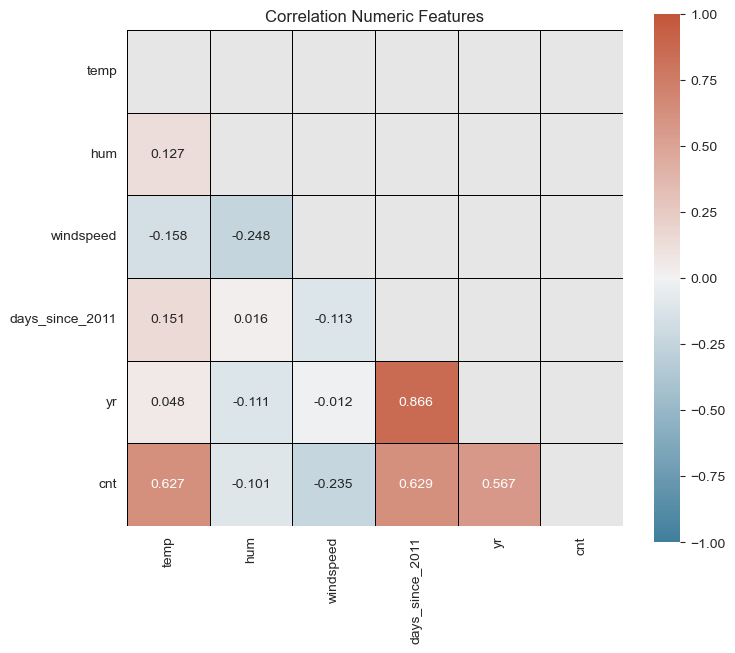

In [6]:
corr_df = raw_data_df[numeric_features + [target]].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set(title='Correlation Numeric Features');

The variables `temp` and `days_since_2011` have a high correlation with the target variable. The former is explaining the seasonality and the later the trend. This hints these could be good predictors. For completeness let us plot the joint distributions:

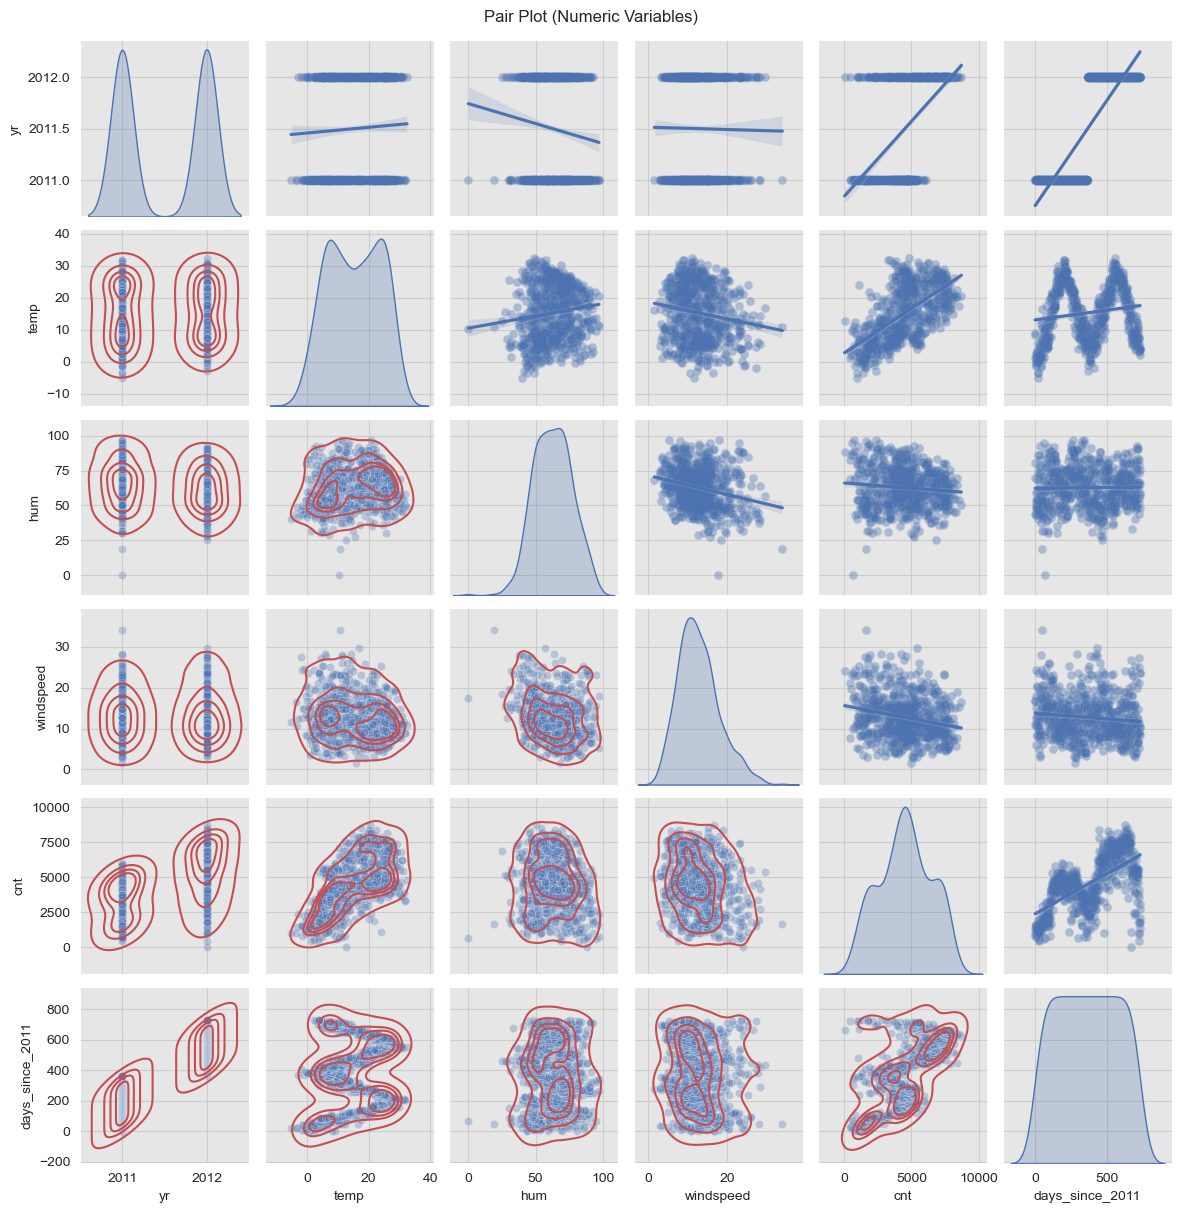

In [7]:
g = sns.pairplot(
    data=raw_data_df,
    diag_kind='kde',
    height=2, 
    corner=False,
    plot_kws={'alpha': 0.3}
)
g.map_lower(sns.kdeplot, levels=5, color=sns_c[3])
g.map_upper(sns.regplot, color=sns_c[0], scatter_kws={'alpha': 0.1})
g.fig.suptitle('Pair Plot (Numeric Variables)', y=1.01);

- Categorical Features

Let us compute the mean of `cnt` per each categorical variable:

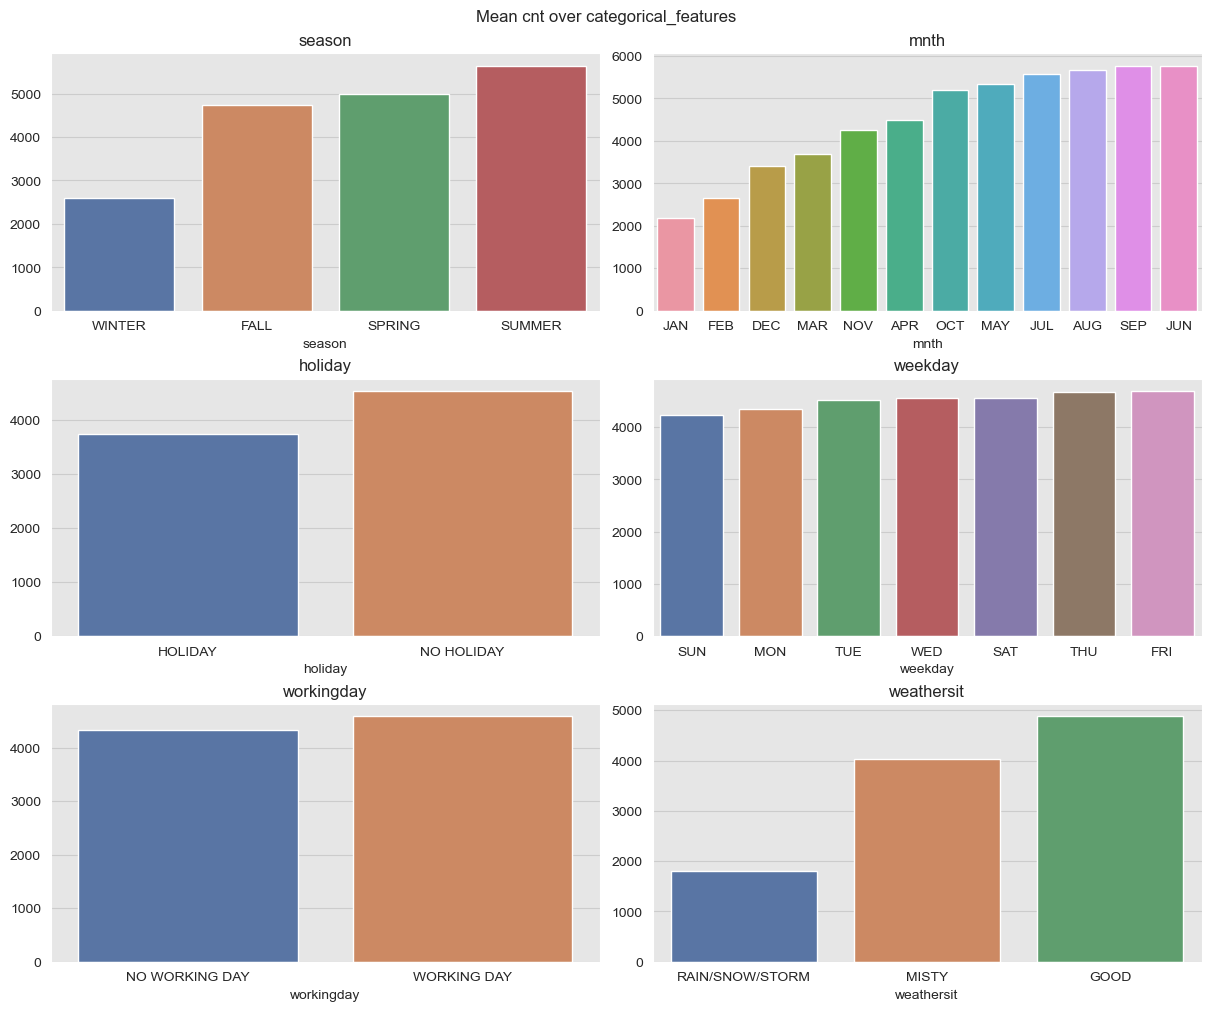

In [8]:
categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
]

fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 10),
    constrained_layout=True
)

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = axes[i]

    feature_df = raw_data_df \
        .groupby(feature, as_index=False) \
        .agg({target: np.mean}) \
        .sort_values(target)

    sns.barplot(
        x=feature,
        y=target,
        data=feature_df,
        dodge=False,
        ax=ax
    )
    ax.set(title=feature, ylabel=None)

fig.suptitle(f'Mean {target} over categorical_features');

Let us now take a look into the distributions:

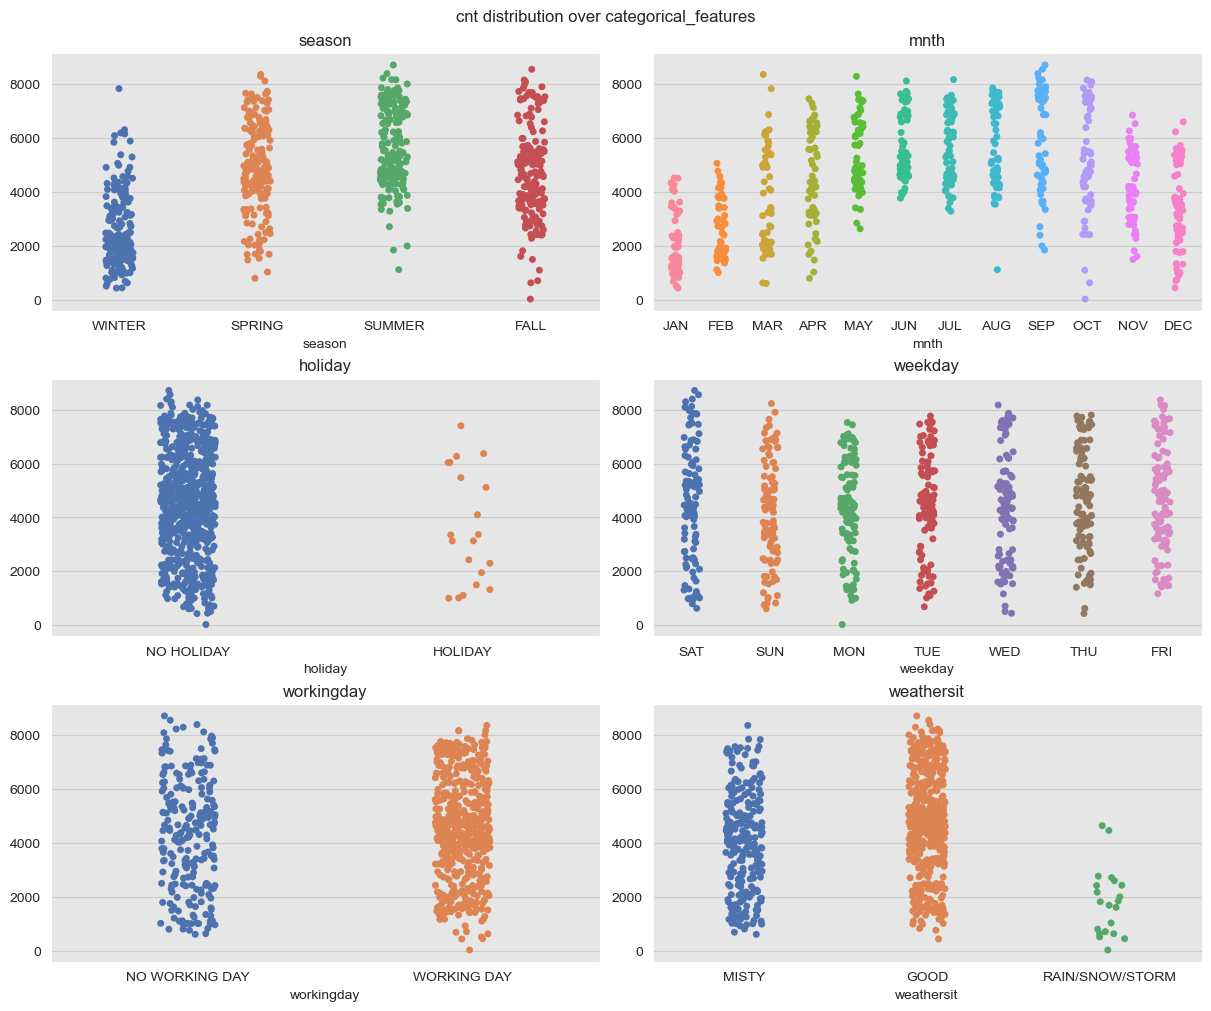

In [9]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 10),
    constrained_layout=True
)

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    sns.stripplot(
        x=feature,
        y=target,
        data=raw_data_df,
        dodge=False,
        ax=ax
    )
    ax.set(title=feature, ylabel=None)
fig.suptitle(f'{target} distribution over categorical_features');

This plot also hints that the categorical features could serve as predictors as, for example, we clearly see how in cooler months the bike counts is lower than warmer months.

**Remark:** The variables `season` and `mnth` seem redundant. Still we want to include them both in the model to see how the tools to interpret the model react to it.

## Train - Test Split

As we have a time series problem we do a train test split without shuffle.

In [10]:
from sklearn.model_selection import train_test_split

x = raw_data_df.copy().drop([target], axis=1)
y = raw_data_df.copy()[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42, shuffle=False
)

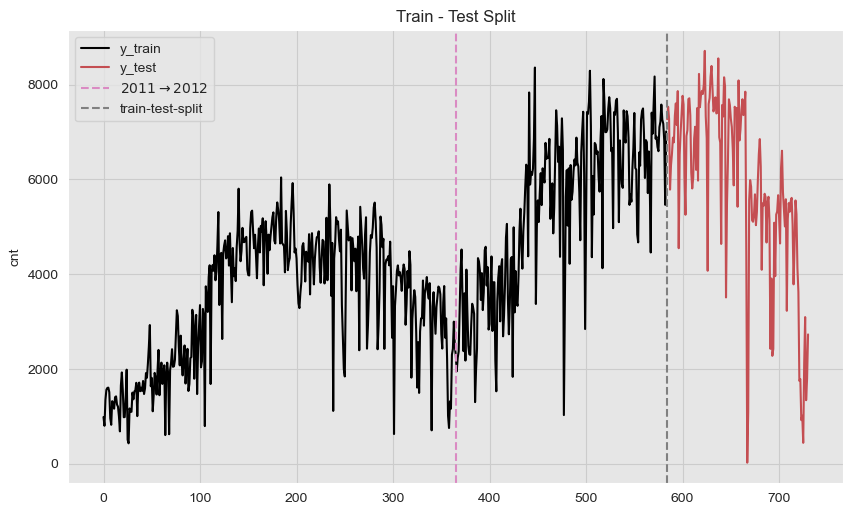

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, color='black', label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[3], label='y_test', ax=ax)
ax.axvline(x=365, color=sns_c[6], linestyle='--', label=r'$2011 \rightarrow 2012$')
ax.axvline(x=y_train.shape[0], color='gray', linestyle='--', label='train-test-split')
ax.legend(loc='upper left')
ax.set(title='Train - Test Split');

Note that there seems to be a difference between the variance and trend between 2011 and 2012. This hints that the variable `yr` could be important for the prediction task.

## Model Development 

We want to train two kind of models: (1) a linear model ([`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)) and (2) a tree based model ([`xgboost`](https://xgboost.readthedocs.io/en/latest/)). Our scoring metric is the [mean-squared-error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error).

Let us now define some preprocessing steps: scaling and one-hot-encoding.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
]

numeric_features = [
    'temp',
    'hum',
    'windspeed',
    'days_since_2011',
    'yr',
]

features = categorical_features + numeric_features

x_train = x_train[features]
x_test = x_test[features]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder())
])

For future reference, let us get the names of the model features after the preprocessing step:

In [13]:
# Warning: One needs to be careful with the variables
# ordering in view of the ColumnTransformer steps below.
categorical_features_ext = list(
        categorical_transformer['one_hot'] \
        .fit(x_train[categorical_features]) \
        .get_feature_names_out(categorical_features)
    ) 
features_ext = categorical_features_ext + numeric_features

print(f'Number of features after pre-processing: {len(features_ext)}')

Number of features after pre-processing: 35


In [14]:
', '.join(features_ext)

'season_FALL, season_SPRING, season_SUMMER, season_WINTER, mnth_APR, mnth_AUG, mnth_DEC, mnth_FEB, mnth_JAN, mnth_JUL, mnth_JUN, mnth_MAR, mnth_MAY, mnth_NOV, mnth_OCT, mnth_SEP, holiday_HOLIDAY, holiday_NO HOLIDAY, weekday_FRI, weekday_MON, weekday_SAT, weekday_SUN, weekday_THU, weekday_TUE, weekday_WED, workingday_NO WORKING DAY, workingday_WORKING DAY, weathersit_GOOD, weathersit_MISTY, weathersit_RAIN/SNOW/STORM, temp, hum, windspeed, days_since_2011, yr'

**Remark:** Note that we have not drop any categorical variable from the one-hot-encoding as we will use regularization in our models, see on [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) *(...) dropping one category breaks the symmetry of the original representation and can therefore induce a bias in downstream models.*

### Linear Model

The first model is a ([`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)) regression with a second order multiplicative interaction between the input features (we actually remove the purely quadratic terms and just include the interactions). We use this type of model with $L^1$-regularization in order to do a variable selection via time-slice-cross validation. We remove zero-variance features (comming for example as an interaction of orthogonal features) with a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) transformer.

In [15]:
linear_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
], remainder='passthrough')

linear_feature_engineering = Pipeline(steps=[
    ('linear_preprocessor', linear_preprocessor),
    ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('variance_threshold', VarianceThreshold()),
])

linear_pipeline = Pipeline(steps=[
    ('linear_feature_engineering', linear_feature_engineering),
    ('linear_regressor', Lasso())
])

linear_param_grid = {
    'linear_regressor__alpha': np.logspace(start=-3, stop=3, num=20),
}

cv = TimeSeriesSplit(n_splits=5, test_size=(7 * 2), gap=0)

linear_grid_search = GridSearchCV(
    estimator=linear_pipeline,
    param_grid=linear_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

In [16]:
# Fit the linear model.
linear_grid_search = linear_grid_search.fit(X=x_train, y=y_train)

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+07, tolerance: 1.304e+05
  model = cd_fast.enet_coordinate_descent(
/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.946e+07, tolerance: 1.448e+05
  model = cd_fast.enet_coordinate_descent(
/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

### Tree Model

The second model is an [`xgboost`](https://xgboost.readthedocs.io/en/latest/) model.

In [17]:
tree_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

tree_feature_engineering = Pipeline(steps=[
    ('tree_preprocessor', tree_preprocessor)
])

tree_pipeline = Pipeline(steps=[
    ('tree_feature_engineering', tree_feature_engineering),
    ('tree_regressor',  XGBRegressor())
])

tree_param_grid = {
    'tree_regressor__min_child_weight': [0.01, 0.5, 1, 10],
    'tree_regressor__max_depth': [3, 5, 8, 13]
}

tree_grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

In [18]:
# Fit the model.
tree_grid_search = tree_grid_search.fit(X=x_train, y=y_train)

## Model Performance

Let us now compare the (in / out) sample performance of these models.

First let us generate predictions on the train and test sets:

In [19]:
y_train_pred_linear = linear_grid_search.predict(X=x_train)
y_test_pred_linear = linear_grid_search.predict(X=x_test)

y_train_pred_tree = tree_grid_search.predict(X=x_train)
y_test_pred_tree = tree_grid_search.predict(X=x_test)

In [20]:
from sklearn.metrics import mean_squared_error

print(f'''
--------------------------------
train mse (linear): {mean_squared_error(y_true=y_train, y_pred=y_train_pred_linear): 0.2f}
test  mse (linear): {mean_squared_error(y_true=y_test, y_pred=y_test_pred_linear): 0.2f}
--------------------------------
train mse (tree)  : {mean_squared_error(y_true=y_train, y_pred=y_train_pred_tree): 0.2f}
test  mse (tree)  : {mean_squared_error(y_true=y_test, y_pred=y_test_pred_tree): 0.2f}
--------------------------------
''')


--------------------------------
train mse (linear):  213555.13
test  mse (linear):  1363559.49
--------------------------------
train mse (tree)  :  69297.93
test  mse (tree)  :  1317805.48
--------------------------------



Both models have a similar out-sample performance (the tree one does a bit better). For in-sample performance the tree based model has less MSE.

**Warning:** One needs to be careful when using tee based model for time series forecasting as these models are not capable of capturing trend components. In this specific case the trend is no s strong and the overall range of the time series is bounded by the max / min of the training time series. This explains why the tree based model still performs well on the test set.

Let us plot the predictions and error distributions on the training and test sets:

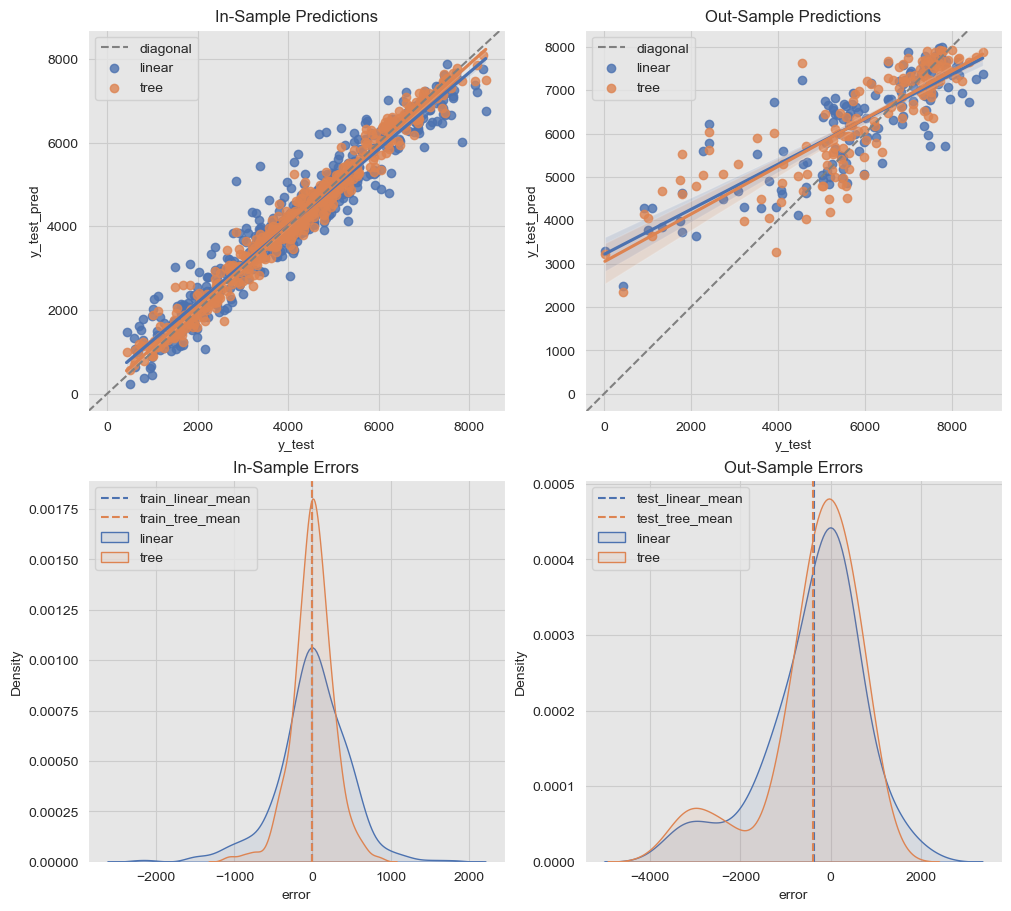

In [21]:
# Compute errors.
error_train_linear = y_train - y_train_pred_linear
error_test_linear = y_test - y_test_pred_linear
error_train_tree = y_train - y_train_pred_tree
error_test_tree = y_test - y_test_pred_tree

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), constrained_layout=True)

ax = ax.flatten()

sns.regplot(x=y_train, y=y_train_pred_linear, color=sns_c[0], label='linear', ax=ax[0])
sns.regplot(x=y_train, y=y_train_pred_tree, color=sns_c[1], label='tree', ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend(loc='upper left')
ax[0].set(title='In-Sample Predictions', xlabel='y_test', ylabel='y_test_pred')

sns.regplot(x=y_test, y=y_test_pred_linear, color=sns_c[0], label='linear', ax=ax[1])
sns.regplot(x=y_test, y=y_test_pred_tree, color=sns_c[1], label='tree', ax=ax[1])
ax[1].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[1].legend(loc='upper left')
ax[1].set(title='Out-Sample Predictions', xlabel='y_test', ylabel='y_test_pred')

sns.kdeplot(x=error_train_linear, color=sns_c[0], label='linear', fill=True, alpha=0.1, ax=ax[2])
sns.kdeplot(x=error_train_tree, color=sns_c[1], label='tree', fill=True, alpha=0.1, ax=ax[2])
ax[2].axvline(x=error_train_linear.mean(), color=sns_c[0], linestyle='--', label='train_linear_mean')
ax[2].axvline(x=error_train_tree.mean(), color=sns_c[1], linestyle='--', label='train_tree_mean')
ax[2].legend(loc='upper left')
ax[2].set(title='In-Sample Errors', xlabel='error')

sns.kdeplot(x=error_test_linear, color=sns_c[0], label='linear', fill=True, alpha=0.1, ax=ax[3])
sns.kdeplot(x=error_test_tree, color=sns_c[1], label='tree', fill=True, alpha=0.1, ax=ax[3])
ax[3].axvline(x=error_test_linear.mean(), color=sns_c[0], linestyle='--', label='test_linear_mean')
ax[3].axvline(x=error_test_tree.mean(), color=sns_c[1], linestyle='--', label='test_tree_mean')
ax[3].legend(loc='upper left')
ax[3].set(title='Out-Sample Errors', xlabel='error');

Now let us visualize the predictions as a time series:

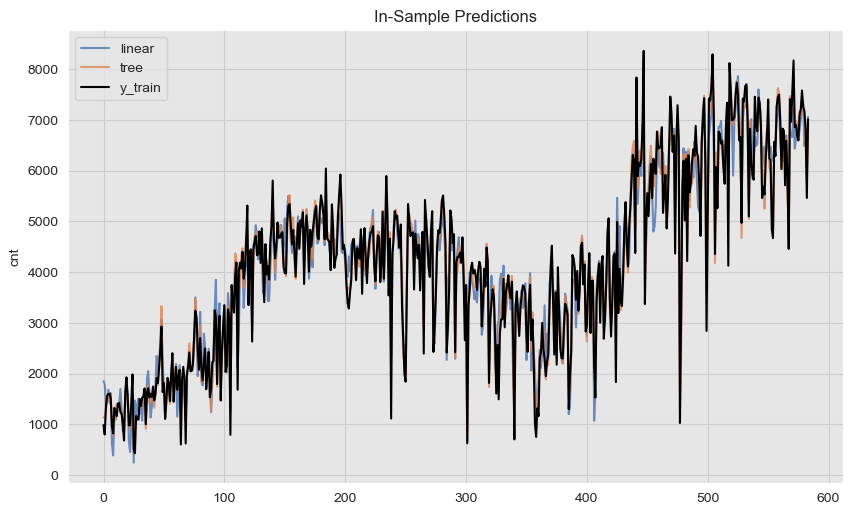

In [22]:
fig, ax = plt.subplots()

sns.lineplot(
    x=range(y_train_pred_linear.shape[0]),
    y=y_train_pred_linear,
    color=sns_c[0],
    label='linear',
    alpha=0.8,
    ax=ax
)

sns.lineplot(
    x=range(y_train_pred_linear.shape[0]),
    y=y_train_pred_tree,
    color=sns_c[1],
    label='tree',
    alpha=0.8,
    ax=ax
)

sns.lineplot(
    x=range(y_train.shape[0]),
    y=y_train,
    color='black',
    label='y_train',
    ax=ax
)

ax.set(title='In-Sample Predictions');

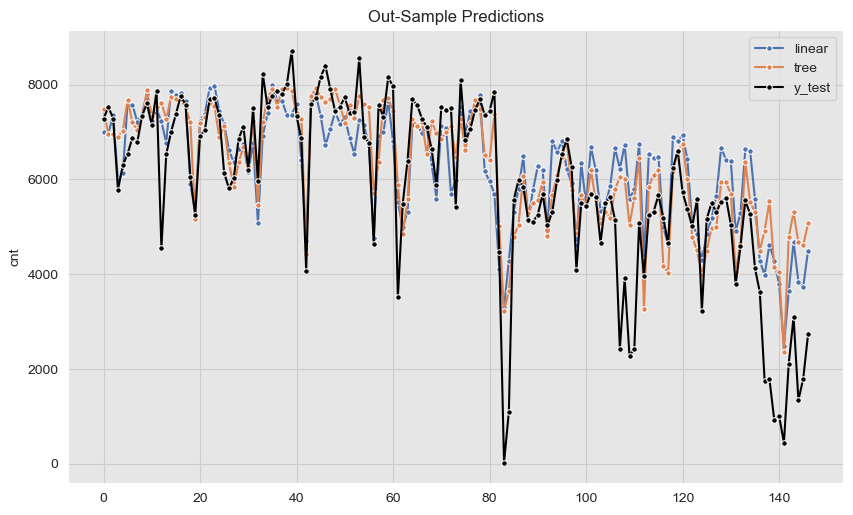

In [23]:
fig, ax = plt.subplots()

sns.lineplot(
    x=range(y_test_pred_linear.shape[0]),
    y=y_test_pred_linear,
    color=sns_c[0],
    marker='o',
    markersize=4,
    label='linear',
    ax=ax
)

sns.lineplot(
    x=range(y_test_pred_tree.shape[0]),
    y=y_test_pred_tree,
    color=sns_c[1],
    marker='o',
    markersize=4,
    label='tree',
    ax=ax
)

sns.lineplot(
    x=range(y_test.shape[0]),
    y=y_test,
    color='black',
    marker='o',
    markersize=4,
    label='y_test',
    ax=ax
)

ax.set(title='Out-Sample Predictions');

---
# Part II: Model Interpretation

Now that we have fitted two machine learning models, we would like to try to understand how these models make predictions, e.g. which features are important? are there any interaction effects? what is the effect on certain feature on the final outcome? We will start to answer these questions by looking into the individual model structure and extract some insights based on the algorithm behind the model. After that, we will deep dive into model-agnostic methods.

## Model Specific

Let us now dig deeper into model specific methods to understand the model predictions.

### Linear Model

Linear models are arguably the most interpretable ones as the parametrization is very transparent. For a given target variable `y` and regressors `x_k` a linear model has the form 

$$
y = \beta_{0} + x_{1}\beta_{1} + \cdots + \beta_{k}x_{k} + \cdots \beta_{p}x_{p} + \varepsilon 
$$

where the weights (beta coefficients) $\beta_{i}$ are the parameters to be estimated from the data ($\beta_{0}$ denotes the model intercept) and $\varepsilon \sim N(0, \sigma^{2})$ is an error term. Still, one needs to be careful whenever there are highly correlated variables or multicollinearity. For details on interpretability of linear models see [Section 4.1, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/limo.html). 

We want to compare and understand the beta coefficient of our linear model. First let us extract the features feeding the model:

In [24]:
from itertools import compress

# Polynomial feature names.
polynomial_features = linear_grid_search \
    .best_estimator_['linear_feature_engineering']['polynomial'] \
    .get_feature_names_out(features_ext)

# Mask for variables with zero-variance
variance_threshold_support = linear_grid_search \
    .best_estimator_['linear_feature_engineering']['variance_threshold'] \
    .get_support()

linear_features = list(
    compress(data=polynomial_features, selectors=variance_threshold_support)
)

Let us store the linear features after preprocessing in a dataframe.

In [25]:
linear_x_train = pd.DataFrame(
    data=linear_grid_search.best_estimator_['linear_feature_engineering'].transform(x_train),
    columns=linear_features
)

Next let us extract the model $\beta$ coefficients.

In [26]:
linear_model_coef_df = pd.DataFrame(data={
    'linear_features': linear_features,
    'coef_': linear_grid_search.best_estimator_['linear_regressor'].coef_
})

linear_model_coef_df = linear_model_coef_df \
    .assign(abs_coef_ = lambda x: x['coef_'].abs()) \
    .sort_values('abs_coef_', ascending=False) \
    .reset_index(drop=True)

# Get top (abs) beta coefficients.
linear_model_coef_df \
    .head(20) \
    .style.background_gradient(
        cmap='viridis_r',
        axis=0,
        subset=['abs_coef_']
    )

Here are few observations:

- The variable with highest beta coefficient is `weathersit_RAIN/SNOW/STORM`, which hints that days with particularly bad weather have lower rental counts.
- Even though `mnth_JUL` and `temp` have positive beta coefficients, the interaction term `mnth_JUL temp` has a very low beta coefficient. This decreases the effect of temperature (see weight effect below) in the month of July as compared to other month.

In [27]:
# Let us get the model intercept.
linear_model_intercept = linear_grid_search.best_estimator_['linear_regressor'].intercept_

These coefficients depend on the scale of each variable (note that we normalized all the features in the pre-processing step). To get a scale-free weight effect we multiply these coefficients with each feature instance, so that the effect on the variable $x_{k}$ on the data instance $(y^{i}, x^{i})$ is $\beta_{k}x_{k}^{i}$.

In [28]:
linear_model_effects = np.multiply(
    linear_grid_search.best_estimator_['linear_regressor'].coef_,
    linear_grid_search.best_estimator_['linear_feature_engineering'].transform(x_train)
)

linear_model_effects_df = pd.DataFrame(
    data=linear_model_effects,
    columns=linear_features
)

Let us plot top weight effects:

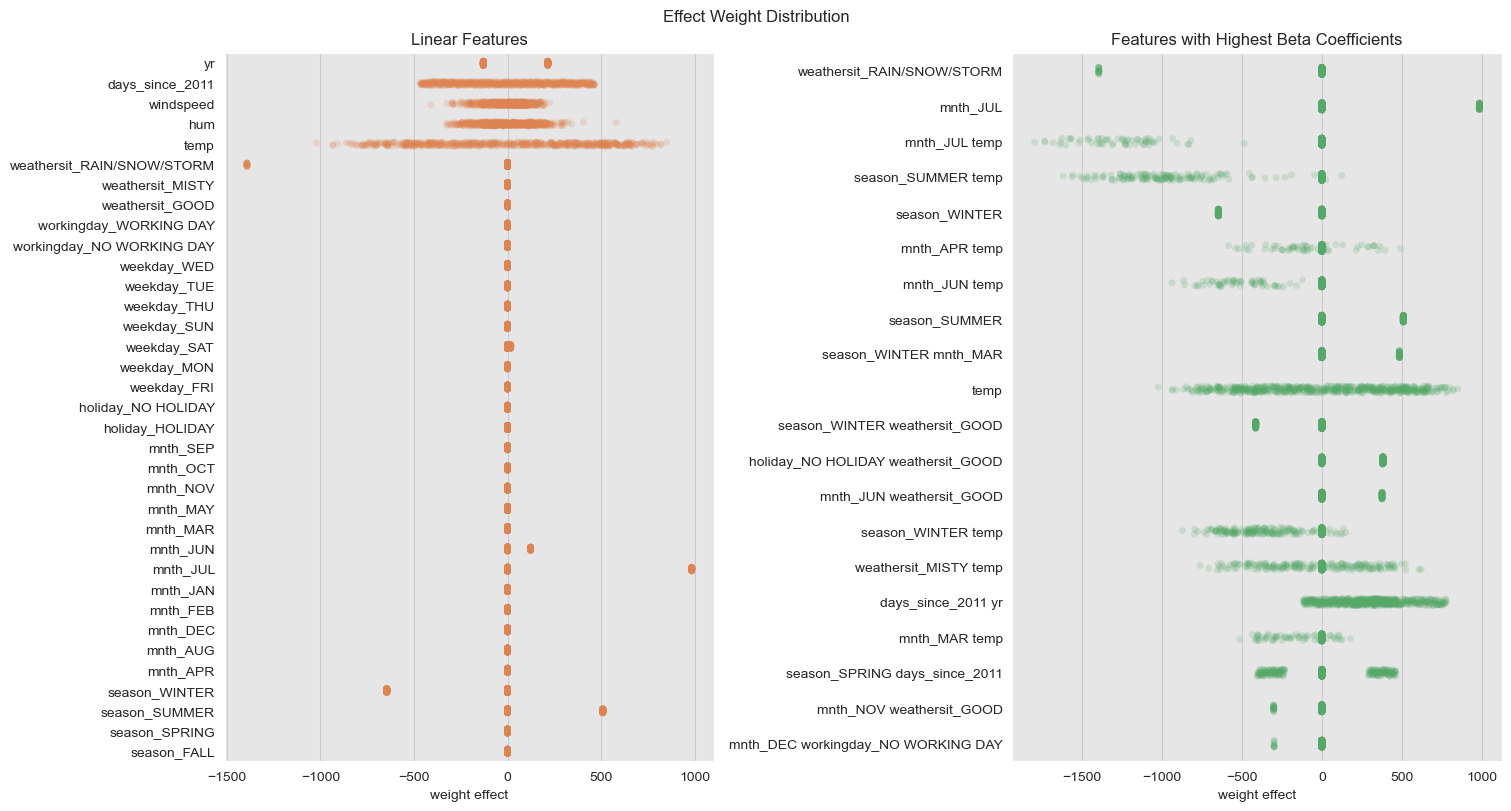

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True) 
# Weight effects distribution of the all linear terms.
sns.stripplot(
    data=linear_model_effects_df[features_ext[::-1]],
    orient='h',
    color=sns_c[1],
    alpha=0.2,
    ax=ax[0]
)
ax[0].set(
    title='Linear Features',
    xlabel='weight effect'
)
# Weight effects distribution of the terms 
# (including intraction) with highest beta coefficients;
sns.stripplot(
    data=linear_model_effects_df[linear_model_coef_df.head(20)['linear_features']],
    orient='h',
    color=sns_c[2],
    alpha=0.2,
    ax=ax[1]
)
ax[1].set(
    title='Features with Highest Beta Coefficients',
    xlabel='weight effect'
)
fig.suptitle('Effect Weight Distribution');

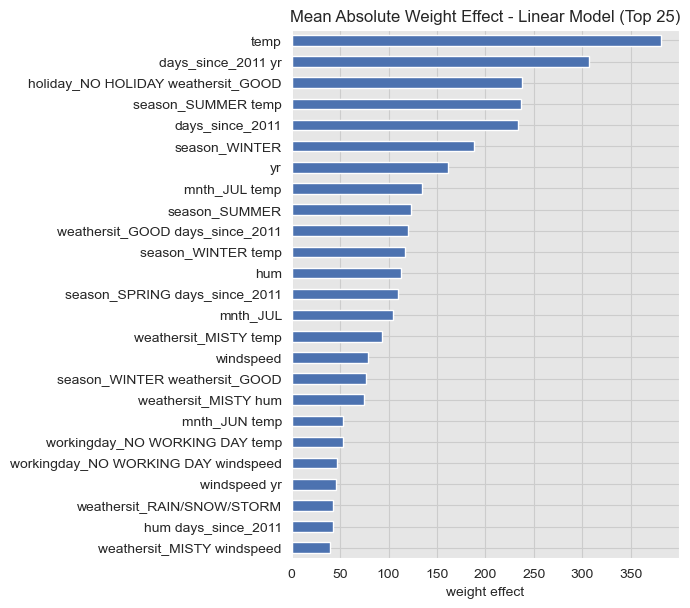

In [30]:
fig, ax = plt.subplots(figsize=(5, 7))
linear_model_effects_df \
    .abs() \
    .mean(axis=0) \
    .sort_values() \
    .tail(25) \
    .plot(
        kind='barh',
        ax=ax
    )
ax.set(
    title='Mean Absolute Weight Effect - Linear Model (Top 25)',
    xlabel='weight effect'
);

Note that `temp`, and `days_since_2011` with the interaction with `yr` are the top 3 features. This can be seen as the main components explaining the trend, seasonality and increasing variance. However ... TODO: Add explanation other variables.

Let us deep dive into some individual features. For example, lets see at which temperature the effect of this variable is negative:

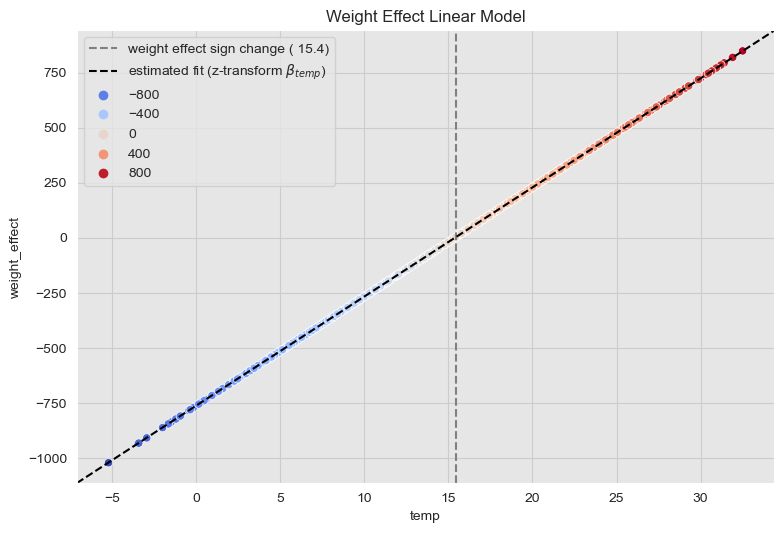

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(
    x=x_train['temp'],
    y=linear_model_effects_df['temp'],
    hue=linear_model_effects_df['temp'].rename('weight_effect'),
    palette='coolwarm',
    ax=ax
)
# Compute sign change point.
cp = x_train['temp'].iloc[linear_model_effects_df['temp'].abs().argmin(), ]
ax.axvline(
    x=cp,
    color='gray',
    linestyle='--',
    label=f'weight effect sign change ({cp: 0.1f})'
)
# Estimated line. We take the inverse z-transform of the estimated beta coefficient.
beta_temp = linear_model_coef_df.query('linear_features == "temp"')['coef_'].values[0]
ax.axline(
    xy1=(x_train['temp'].mean(), 0),
    slope= beta_temp / x_train['temp'].std(),
    color='black',
    linestyle='--',
    label=r'estimated fit (z-transform $\beta_{temp}$)'
)
ax.legend()
ax.set(title='Weight Effect Linear Model', xlabel='temp', ylabel='weight_effect');

**Warning:** This plot just shows the effect of the linear term `temp` and not the interactions.

We can do something similar to visualize the interaction of 2 features. For example for `temp` and `hum` we compute the total weight effect as 
$$
\beta_{temp}x_{temp} + \beta_{hum}x_{hum} + \beta_{temp \times hum}x_{temp} \times x_{hum}
$$

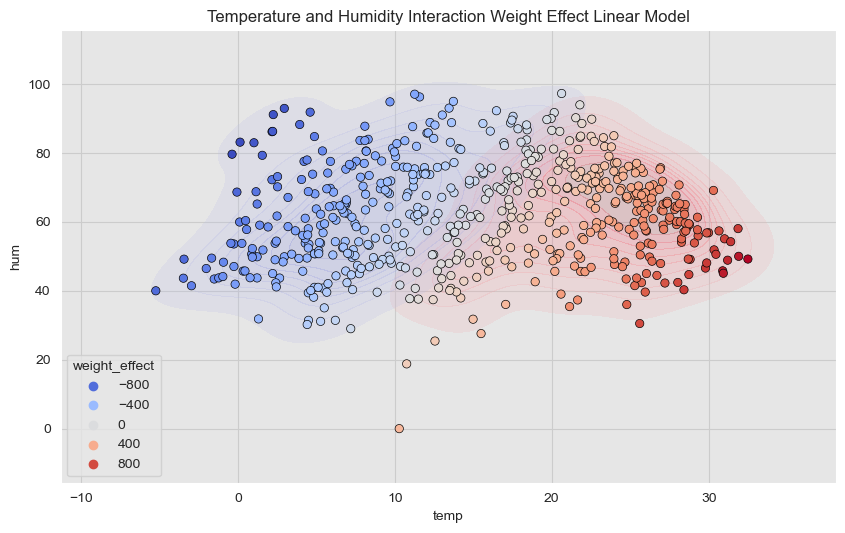

In [32]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
# Compute total weight effect.
sns.kdeplot(
    x=x_train['temp'],
    y=x_train['hum'],
    levels=10,
    hue=(linear_model_effects_df['temp']
         + linear_model_effects_df['hum']
         + linear_model_effects_df['temp hum']
    ) > 0,
    hue_order=[True, False],
    palette=[
        cm.get_cmap('coolwarm_r')(1),
        cm.get_cmap('coolwarm')(1)
    ],
    alpha=0.2,
    fill=True,
    ax=ax
)
# Data Density.
sns.scatterplot(
    x=x_train['temp'],
    y=x_train['hum'],
    hue=(linear_model_effects_df['temp']
         + linear_model_effects_df['hum']
         + linear_model_effects_df['temp hum']
    ),
    palette='coolwarm',
    edgecolor='black',
    ax=ax
)
ax.legend(title='weight_effect', loc='lower left')
ax.set(title='Temperature and Humidity Interaction Weight Effect Linear Model');

Similarly for `hum` and `windspeed`:

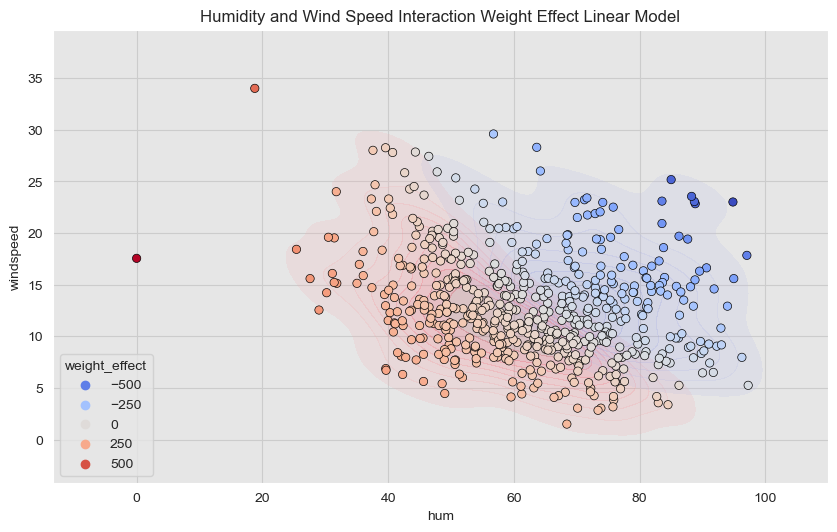

In [33]:
fig, ax = plt.subplots()
# Compute total weight effect.
sns.kdeplot(
    x=x_train['hum'],
    y=x_train['windspeed'],
    levels=10,
    hue=(linear_model_effects_df['windspeed']
         + linear_model_effects_df['hum']
        + linear_model_effects_df['hum windspeed']
    ) > 0,
    hue_order=[True, False],
    palette=[
        cm.get_cmap('coolwarm_r')(1),
        cm.get_cmap('coolwarm')(1)
    ],
    alpha=0.2,
    fill=True,
    ax=ax
)
# Data Density.
sns.scatterplot(
    x=x_train['hum'],
    y=x_train['windspeed'],
    hue=(linear_model_effects_df['windspeed']
         + linear_model_effects_df['hum']
         + linear_model_effects_df['hum windspeed']
    ),
    palette='coolwarm',
    edgecolor='black',
    ax=ax
)
ax.legend(title='weight_effect', loc='lower left')
ax.set(title='Humidity and Wind Speed Interaction Weight Effect Linear Model');

We can also investigate how the model features affect individual predictions:

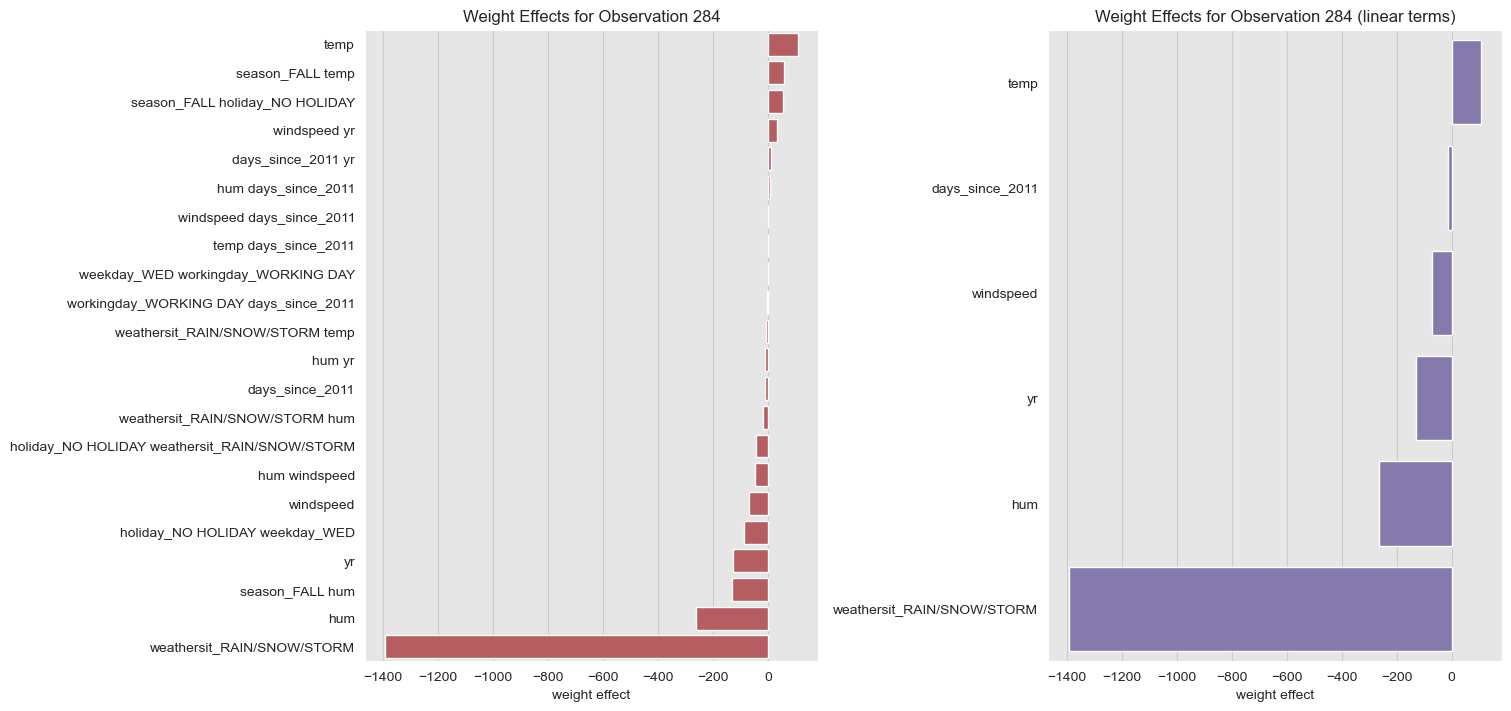

In [34]:
# Compare with FIGURE 5.49 in https://christophm.github.io/interpretable-ml-book/shapley.html.
obs_index = (285 - 1) # Python indexing starts in 0 and not 1 as in R.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), constrained_layout=True)
# All features.
linear_model_effects_df.iloc[obs_index, ] \
    .to_frame() \
    .rename(columns={obs_index: 'effect'}) \
    .query('effect != 0') \
    .reset_index(drop=False) \
    .sort_values('effect', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='effect',
        y='index',
        color=sns_c[3],
        ax=ax[0]
    )
ax[0].set(
    title=f'Weight Effects for Observation {obs_index}',
    xlabel='weight effect',
    ylabel=''
)
# Linear features.
linear_model_effects_df.iloc[obs_index, ] \
    .to_frame() \
    .rename(columns={obs_index: 'effect'}) \
    .query('effect != 0 and index in @features_ext') \
    .reset_index(drop=False) \
    .sort_values('effect', ascending=False) \
    .pipe((sns.barplot, 'data'), 
    x='effect',
    y='index',
    color=sns_c[4],
    ax=ax[1]
)
ax[1].set(
    title=f'Weight Effects for Observation {obs_index} (linear terms)',
    xlabel='weight effect',
    ylabel=''
);

In [35]:
# Input Features for this observation.
x_train.iloc[obs_index, ]

season                        FALL
mnth                           OCT
holiday                 NO HOLIDAY
weekday                        WED
workingday             WORKING DAY
weathersit         RAIN/SNOW/STORM
temp                     17.536651
hum                         90.625
windspeed                 16.62605
days_since_2011                284
yr                            2011
Name: 284, dtype: object

Let us verify that these weight effects add up to the model prediction (including the intercept term):

In [36]:
linear_model_effects_df.iloc[obs_index, ].sum()  \
    + linear_model_intercept \
    - (linear_grid_search.predict(x_train.iloc[obs_index, ].to_frame().T)[0])

0.0

### Tree Model

Single decision trees are also quite explicit about their interpretation. Moving to ensembles can be a bit tricky, I recommend the section [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) on [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html). One of the highest benefits of tree ensembles is the ability to learn complex and non-linear relations from the data. 

To begin, let us compute the preprocessing step output of the tree model:


In [37]:
tree_x_train = pd.DataFrame(
    data=tree_grid_search.best_estimator_['tree_feature_engineering'].transform(x_train),
    columns=features_ext
)

tree_x_train.shape

(584, 35)

XGBoost model provides various measures of importance, see [Understand your dataset with XGBoost](https://xgboost.readthedocs.io/en/latest/R-package/discoverYourData.html). From the XGBoost documentation:

> - *`Gain` is the improvement in accuracy brought by a feature to the branches it is on.*
>
> - *`Cover` measures the relative quantity of observations concerned by a feature.*
>
> - *`Frequency` / `Weight` is a simpler way to measure the `Gain`. It just counts the number of times a feature is used in all generated trees.*

See also [The Multiple faces of ‘Feature importance’ in XGBoost](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7). Let us compute all of them and compare their relative values:

In [38]:
importance_type = [
    'weight',
    'gain',
    'cover',
    'total_gain',
    'total_cover'
]
# Compute and format variable importance metrics.
tree_feature_importance_df = pd.concat(
    [
        pd.DataFrame.from_dict(
            data=(
                tree_grid_search
                .best_estimator_['tree_regressor']
                .get_booster()
                .get_score(importance_type=t)
            ), 
            orient='index',
            columns=[t]
        ) 
        for t in importance_type
    ],
    axis=1
)

tree_feature_importance_df = tree_feature_importance_df \
    .reset_index(drop=False) \
    .assign(
        index = lambda x: x['index'].str.replace(pat='f', repl='').astype(int)
    )

# Map genertic features of the form f<NUMBER> to the original feature names.
tree_features_idx_map = tree_feature_importance_df['index'].apply(lambda idx: features_ext[idx])

# Relative feature importance.
tree_feature_importance_rel_df = tree_feature_importance_df / tree_feature_importance_df.sum(axis=0)
tree_feature_importance_rel_df = tree_feature_importance_rel_df \
    .assign(feature = tree_features_idx_map) \
    .drop('index', axis=1)

Let us plot the results:

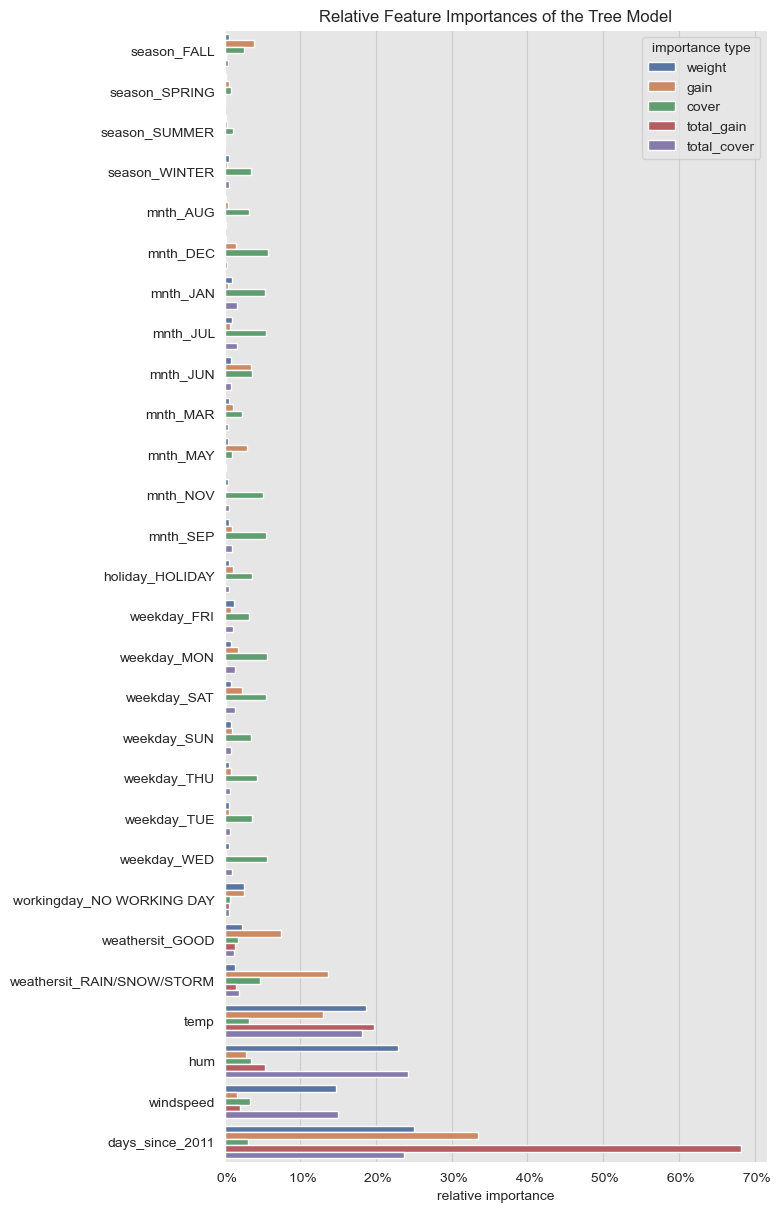

In [39]:
fig, ax = plt.subplots(figsize=(7, 15))
sns.barplot(
    x='value',
    y='feature',
    data=tree_feature_importance_rel_df.melt(id_vars='feature'),
    hue='variable',
    dodge=True,
    ax=ax
)
ax.legend(title='importance type')
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f'{y: .0%}')
)
ax.set(
    title='Relative Feature Importances of the Tree Model',
    xlabel='relative importance',
    ylabel=''
);

It this tree model both `days_from_2011` and `temp` are important variables.

**Waring:** Zero-importance features are not included.

In [40]:
print(f'''
Zero-importance features:
{[x for x in features_ext if x not in tree_feature_importance_rel_df['feature'].values]}
''')


Zero-importance features:
['mnth_APR', 'mnth_FEB', 'mnth_OCT', 'holiday_NO HOLIDAY', 'workingday_WORKING DAY', 'weathersit_MISTY', 'yr']



## Partial Dependence Plot (PDP) & Individual Conditional Expectation (ICE)

In this section we describe the first model-agnostic method to understand how features interact to generate predictions in a machine learning model. Some recommended references on the subject are:

- PDP

    - [Section 5.1, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/pdp.html)

    - [4.1.1. Partial dependence plots, scikit-learn docs](https://scikit-learn.org/stable/modules/partial_dependence.html)

- ICE

    - [Section 5.2, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/ice.html)

    - [4.1.2.  Individual conditional expectation (ICE) plot, scikit-learn docs](https://scikit-learn.org/stable/modules/partial_dependence.html#individual-conditional-expectation-ice-plot)


Let us start by quoting the description of partial dependency plots from the [scikit-learn docs](https://scikit-learn.org/stable/modules/partial_dependence.html):
> *Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features.*

Let us be more concrete. For a regression problem (like in this example) we can estimate the partial dependence function (which is the plot of interest) as follows: Let $x_S$ be the features for which the partial dependence function should be plotted (usually not more than 2 variables) and $x_C$ be other features used in the machine learning model. One can estimate the partial dependence function as

$$
\hat{f}_{x_{S}}(x_{s}) = 
\frac{1}{n}
\sum_{i=1}^{n}
\hat{f}(x_{S}, x_{C}^{i})
$$

where $\hat{f}$ is the model prediction function, $x_{C}^{i}$ are actual feature values (not in $S$) and $n$ is the number points. The following is one of the key assumptions of this method (see [Section 5.1, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/pdp.html))

For example, given a trained model $\hat{f}$, we compute for $\textcolor{red}{temp=8}$
$$
\begin{align*}
\hat{f}_{temp}(\textcolor{red}{temp=8}) = 
\frac{1}{146}
& \left(\hat{f}(\textcolor{red}{temp=8}, hum=80, \cdots) \right.\\
& \left. + \hat{f}(\textcolor{red}{temp=8}, hum=70, \cdots)  + \cdots \right)
\end{align*}
$$

> *An assumption of the PDP is that the features in $C$ are not correlated with the features in $S$. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.*

In view of the correlation matrix computed above for the numeric features, we see that the assumption holds true. However, the categorical variables are not independent, e.g. `season` and `mnth`. 

Similar to a PDP, an individual conditional expectation (ICE) plot shows one line per instance. That is, for each instance in $\{(x_{S}^{i}, x_{C}^{i})\}_{i=1}^{n}$, we plot $\hat{f}_{S}$ as a function of $x_{S}^{i}$ while leaving $x_{C}^{i}$ fixed. Hence, the PDP plot is the average of the lines of an ICE plot. Note that the additional information provided by ICE plots are interaction effects between the features. In PDPs these interactions are untraceable after the aggregation.

Let us plot these curves for the linear model:

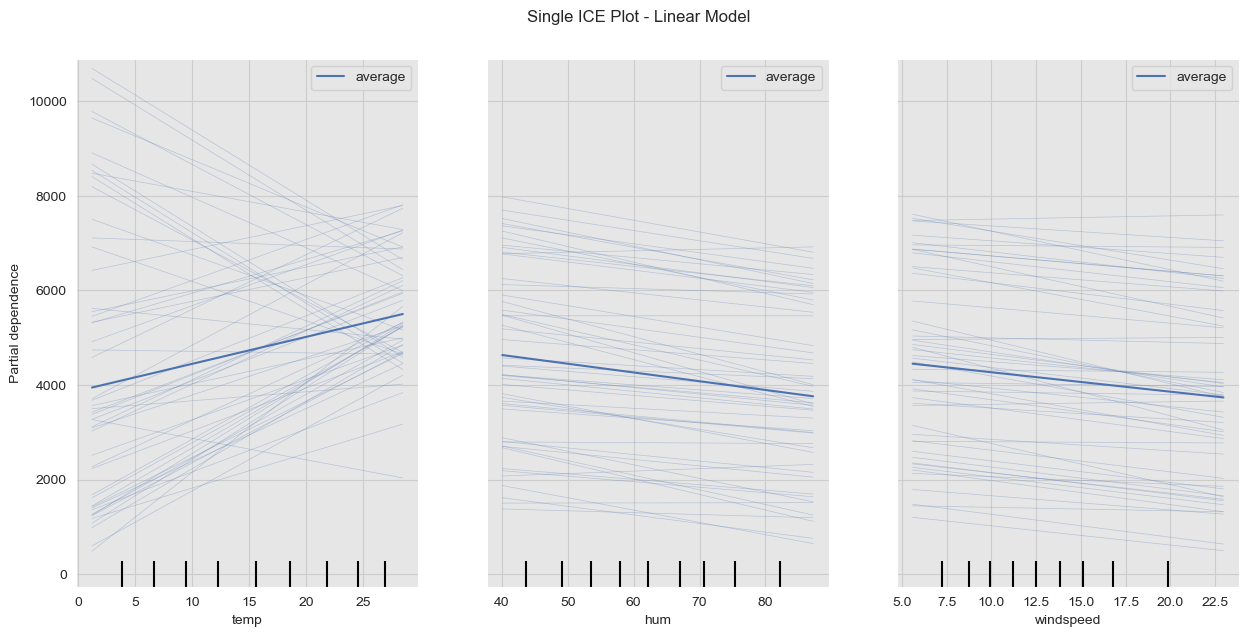

In [41]:
from sklearn.inspection import PartialDependenceDisplay

features_to_display = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots(figsize=(15, 7))

display_linear = PartialDependenceDisplay.from_estimator(
       estimator=linear_grid_search,
       X=x_train,
       features=features_to_display,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       ax=ax
)

fig.suptitle(
       'Single ICE Plot - Linear Model', y=0.95
);

As expected all the PDP curves are straight lines. Note however that there are light lines in the `temp` ICE plot, which indicate unseen interactions by aggregation in the PDP plot.

Let us now compute the PDP for pairs of numeric features.

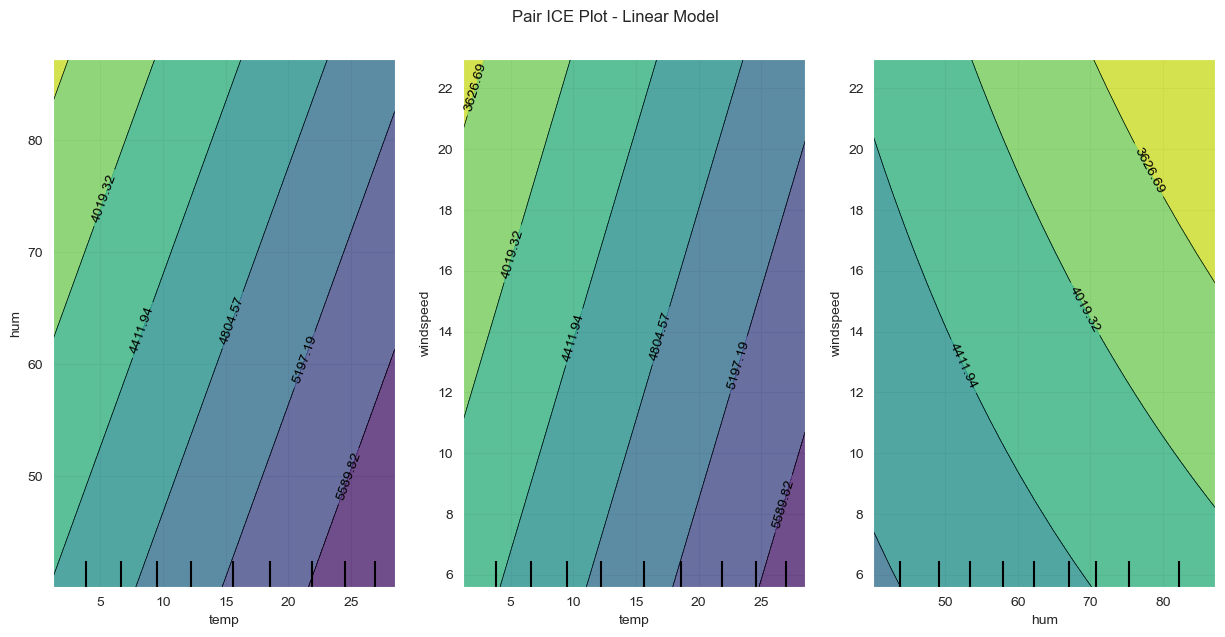

In [42]:
fig, ax = plt.subplots(figsize=(15, 7))

features_to_display = [
    ('temp', 'hum'),
    ('temp', 'windspeed'),
    ('hum', 'windspeed')
]

display_linear = PartialDependenceDisplay.from_estimator(
       estimator=linear_grid_search,
       X=x_train,
       features=features_to_display,
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       contour_kw={'cmap': 'viridis_r'},
       ax=ax
)

fig.suptitle(
       'Pair ICE Plot - Linear Model', y=0.95
);

Note that for the `temp` plots the relation with the other features seem quite linear (also compare with the weight effects scatter plots of the linear model above). On the other hand the `hum` vs `windspeed` PDP is not completely linear. Let us try to understand this by looking into the $\beta$ coefficients:

In [43]:
mask = linear_model_coef_df['linear_features'].isin(
    ["temp", "hum", "windspeed", "temp hum", "temp windspeed", "hum windspeed"]
)

linear_model_coef_df[mask] \
.style.background_gradient(
        cmap='viridis_r',
        axis=0,
        subset=['abs_coef_']
    )

The largest $\beta$ coefficient of the interactions is indeed the one corresponding to `hum windspeed`.

Now let us generate the plots for the tree based model:

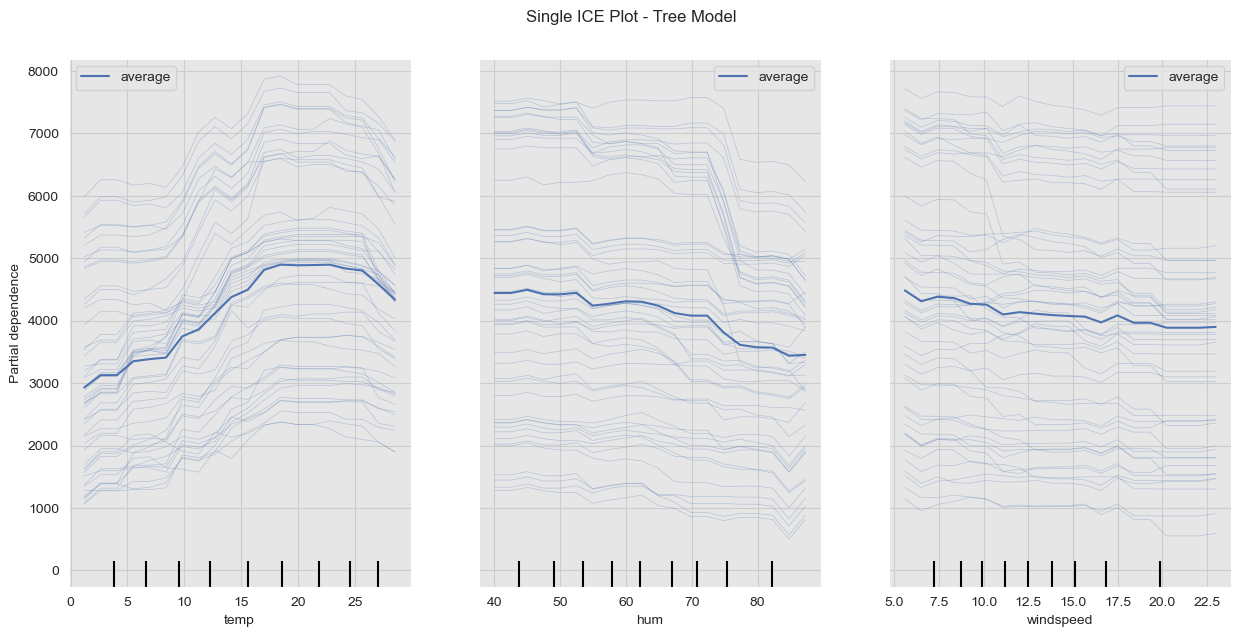

In [44]:
features_to_display = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots(figsize=(15, 7))

display_tree = PartialDependenceDisplay.from_estimator(
       estimator=tree_grid_search,
       X=x_train,
       features=features_to_display,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42,
       ax=ax
)

fig.suptitle(
       'Single ICE Plot - Tree Model', y=0.95
);

The plot above reproduces [Figure 5.7 in Section 5.2, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/ice.html): 

> *For warm but not too hot weather, the model predicts on average a high number of rented bicycles. Potential bikers are increasingly inhibited in renting a bike when humidity exceeds 60%. In addition, the more wind the fewer people like to cycle, which makes sense. Interestingly, the predicted number of bike rentals does not fall when wind speed increases from 25 to 35 km/h, but there is not much training data, so the machine learning model could probably not learn a meaningful prediction for this range. At least intuitively, I would expect the number of bicycles to decrease with increasing wind speed, especially when the wind speed is very high.*

Let us now plot the pair PDP:

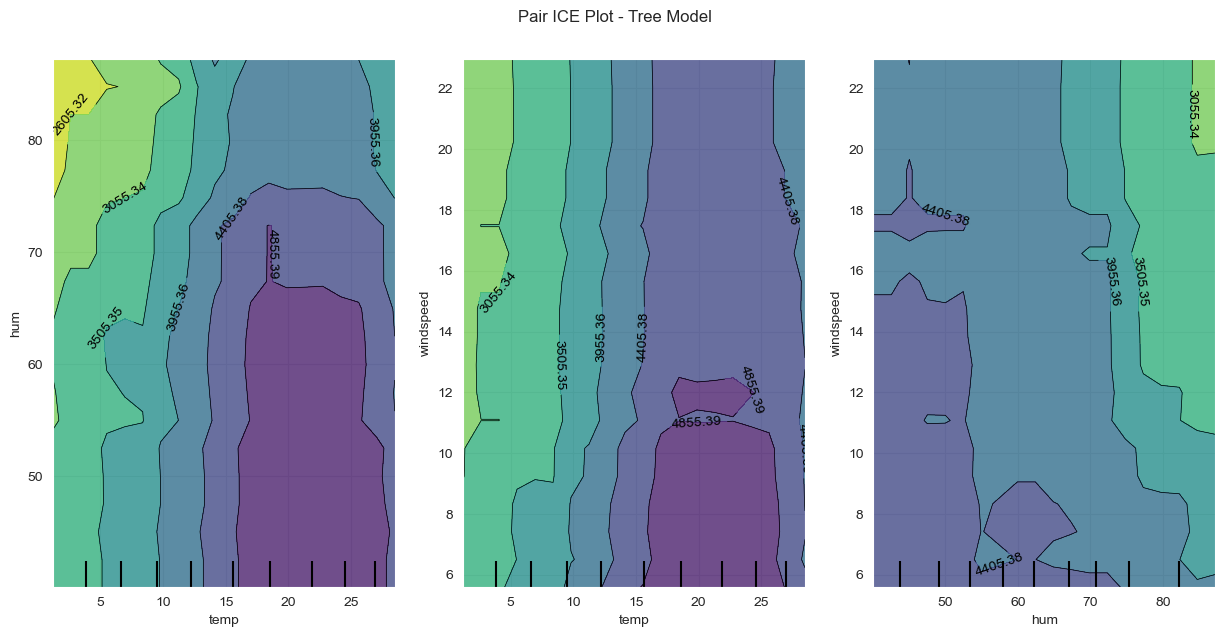

In [45]:
fig, ax = plt.subplots(figsize=(15, 7))

features_to_display = [
    ('temp', 'hum'),
    ('temp', 'windspeed'),
    ('hum', 'windspeed')
]

display_tree = PartialDependenceDisplay.from_estimator(
       estimator=tree_grid_search,
       X=x_train,
       features=features_to_display,
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       contour_kw={'cmap': 'viridis_r'},
       ax=ax
)

fig.suptitle(
       'Pair ICE Plot - Tree Model', y=0.95
);

Let us now plot the first plot above in 3-dimensions (see [scikit-learn: 3D interaction plots](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#id7)):

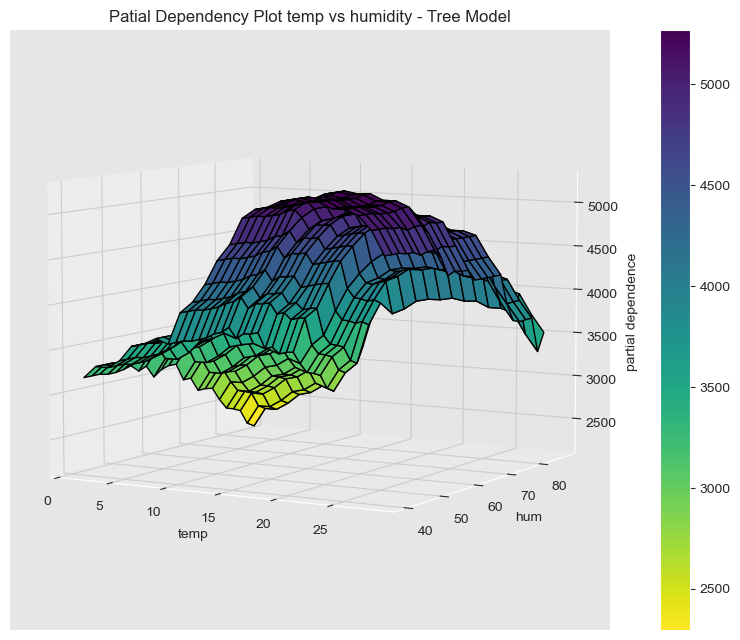

In [46]:
from sklearn.inspection import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

features_to_display = ('temp', 'hum')

pdp = partial_dependence(
    estimator=tree_grid_search,
    X=x_train,
    features=features_to_display, 
    kind='average',
    grid_resolution=25
)

XX, YY = np.meshgrid(pdp['values'][0], pdp['values'][1])
Z = pdp.average[0].T

fig = plt.figure(figsize=(10, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
surf = ax.plot_surface(
    XX,
    YY,
    Z, 
    rstride=1,
    cstride=1,
    cmap='viridis_r',
    edgecolor='black'
)
ax.view_init(elev=7, azim=-60)
ax.set(
    title='Patial Dependency Plot temp vs humidity - Tree Model',
    xlabel=features_to_display[0], 
    ylabel=features_to_display[1],
    zlabel='partial dependence'
)
fig.colorbar(surf);

Finally, let us compare the ICE plots of both models together:

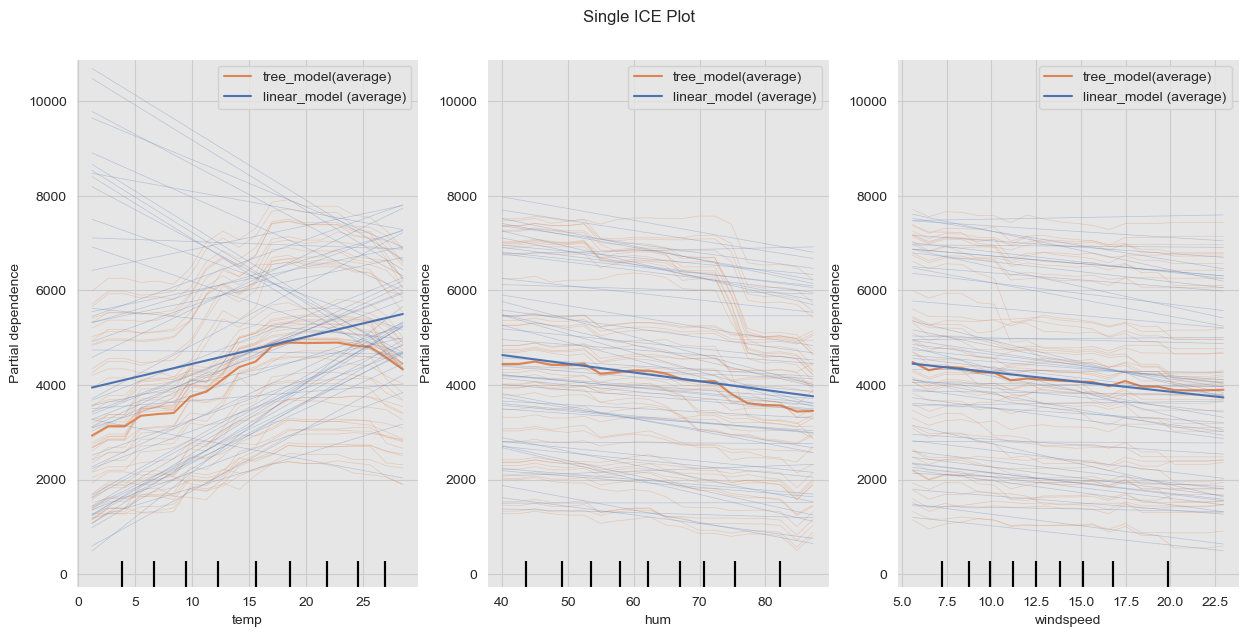

In [47]:
features_to_display = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

display_tree = PartialDependenceDisplay.from_estimator(
       estimator=tree_grid_search,
       X=x_train,
       features=features_to_display,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       line_kw={
           'color': sns_c[1],
           'label': 'tree_model(average)'
        },
       ax=ax
)

display_linear = PartialDependenceDisplay.from_estimator(
       estimator=linear_grid_search,
       X=x_train,
       features=features_to_display,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42,
       line_kw={
           'color': sns_c[0], 'label': 
           'linear_model (average)'
        },
       ax=ax
)

fig.suptitle('Single ICE Plot', y=0.95);

Other useful inspection plots are *accumulated local effects* (ALE) plots, see [Section 5.3, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/ale.html). 

## Permutation Importance

Next, let us discuss *permutation feature importance*, see [Section 5.6, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html):

> *Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.*

**Remark** I encourage you to read [Section 5.5.2, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html#feature-importance-data) where the author discuss whether we should evaluate the feature importance in the train or the test set. In [Interpretable Machine Learning with Python by Serg Masís](https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python), the author provides a similar discussion and decides to evaluate on the test set. In this notebook we do in on the training set in order to be able to reproduce the results in [Interpretable Machine Learning, A Guide for Making Black Box Models Explainable by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/).

Let us compute the permutation feature importance for both models:

In [48]:
from sklearn.inspection import permutation_importance

linear_pi = permutation_importance(
    estimator=linear_grid_search,
    X=x_train,
    y=y_train,
    n_repeats=10
)

tree_pi = permutation_importance(
    estimator=tree_grid_search,
    X=x_train,
    y=y_train,
    n_repeats=10
)

Now lets plot them side-by-side:

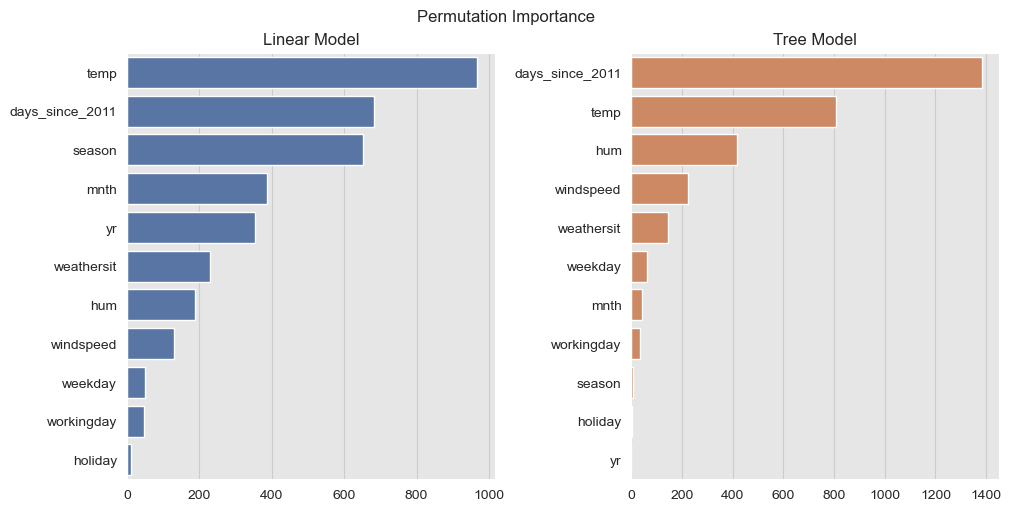

In [49]:
linear_perm_sorted_idx = linear_pi.importances_mean.argsort()[::-1]
tree_perm_sorted_idx = tree_pi.importances_mean.argsort()[::-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)

sns.barplot(
    x=linear_pi.importances_mean[linear_perm_sorted_idx],
    y=x_train.columns[linear_perm_sorted_idx],
    orient='h',
    color=sns_c[0],
    ax=ax[0]
)
ax[0].set(title='Linear Model');

sns.barplot(
    x=tree_pi.importances_mean[tree_perm_sorted_idx],
    y=x_train.columns[tree_perm_sorted_idx],
    orient='h',
    color=sns_c[1],
    ax=ax[1]
)
ax[1].set(title='Tree Model')

fig.suptitle('Permutation Importance');

It is interesting to see that the permutation importance for these two models have `days_since_2021` and `temp` on their top 3 ranking, which partially explain the trend and seasonality components respectively (compare with [FIGURE 5.32](https://christophm.github.io/interpretable-ml-book/feature-importance.html)). Also, these rankings mostly agree with the model-dependent feature importance metrics illustrated above, with the difference that these permutation importance rankings can be obtained at feature level and not per individual one-hot-instance.

**Warning:** Similarly as partial dependency plots, permutation importance  can also be biased by unlikely points in the input data distribution, see [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#permutation-importance-with-multicollinear-or-correlated-features).

In order to analyze the permutation importance ranking while considering the correlation, it useful to have a hierarchical clustering diagram generated from a similarity metric. For example, we can use [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) (to include categorical variables) as suggested in [scikit-learn: Handling Multicollinear Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features)

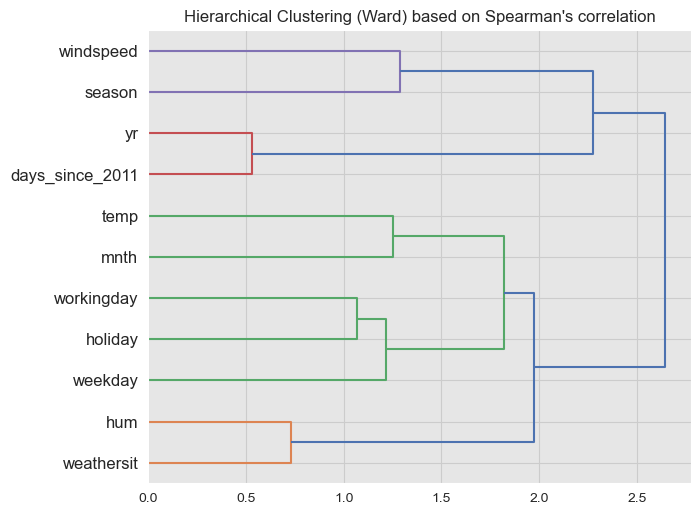

In [50]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

corr = spearmanr(a=x_train).correlation
corr_linkage = hierarchy.ward(y=corr)

fig, ax = plt.subplots(figsize=(7, 6))
dendro = hierarchy.dendrogram(
    Z=corr_linkage,
    labels=x_train.columns, 
    orientation='right',
    ax=ax
)
ax.set(title="Hierarchical Clustering (Ward) based on Spearman's correlation");

Note for example how related features like `days_since_2011` and `yr` differ on their rankings for the tree model. Similarly for `mnth` and `season` in the linear model.

## SHAP

SHAP (SHapley Additive exPlanations) ([Section 5.11, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/shap.html)) are based on the concept of [Shapley Values](https://en.wikipedia.org/wiki/Shapley_value) (see [Section 5.9, Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/shapley.html)), which have their origin in game theory. The main idea is to consider the model as a game (prediction task) and each model feature as a player. Features can be grouped in teams (coalitions) to play thr game, i.e. generate predictions. It is important to remark that the "gain" is the actual prediction for this for the coalition minus the average prediction for all instances, so that:

> *The Shapley value is the average contribution of a feature value to the prediction in different coalitions.*
>
> **Warning:** *The Shapley value is NOT the difference in prediction when we would remove the feature from the model.*

Please visit the references provided for a detailed explanation on Shapley Values. 

How are SHAP values connected to Shapley Values? The idea is to compute SHAP values from local linear models (compare with [LIME](https://christophm.github.io/interpretable-ml-book/lime.html)). Concretely ([KernelShap](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap)), for each instance $x$

> 1. Sample coalitions $z_{k}'\in\{0, 1\}^{M}$, where $M$, is the maximum coalition size.
>
> 2. Get prediction for each $z_{k}'$. For features not in the coalition we replace their values with random samples from the dataset (background data).
>
> 3. Compute the weight for each $z_{k}'$, with the SHAP kernel, 
>
> $$\pi_{x}(z') = \frac{(M-1)}{\binom{M}{|z'|}|z'|(M-|z'|)}$$
>
> 4. Fit weighted linear model.
>
> 5. Return Shapley values, i.e. the coefficients from the linear model.

We are going to use the python [SHAP](https://shap.readthedocs.io/en/latest/index.html) package.

### Linear Model

We can use the general [KernelShap](https://github.com/slundberg/shap/blob/master/shap/explainers/_kernel.py), a generic way to compute the SHAP values as follows:

In [51]:
import shap

# # Get background data: to sample from whenever a feature is missing in a coalition. 
# linear_x_train_summary = shap.kmeans(X=linear_x_train, k=20)

# linear_shap_explainer = shap.KernelExplainer(
#     model=linear_grid_search.best_estimator_['linear_regressor'].predict,
#     data=linear_x_train_summary,
# )

Nevertheless, we can also use optimized implementations for each model type. 

In [52]:
linear_shap_explainer = shap.LinearExplainer(
    model=linear_grid_search.best_estimator_['linear_regressor'],
    masker=shap.maskers.Independent(data=linear_x_train, max_samples=500) # Background data.
)

linear_shap_values = linear_shap_explainer(linear_x_train)

Let us plot the SHAP values for the linear model:

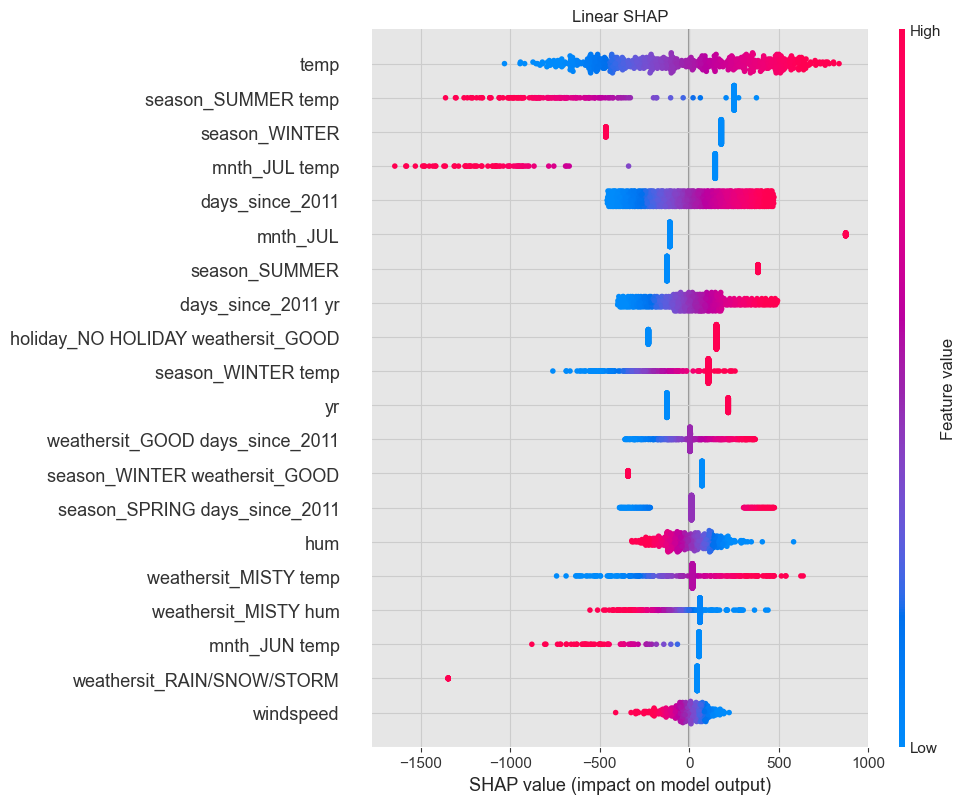

In [53]:
shap.summary_plot(
    shap_values=linear_shap_values,
    features=linear_x_train, 
    show=False
)
plt.title(f'Linear SHAP');

We can also plot the mean of the absolute value of the SHAP values to get a summary:

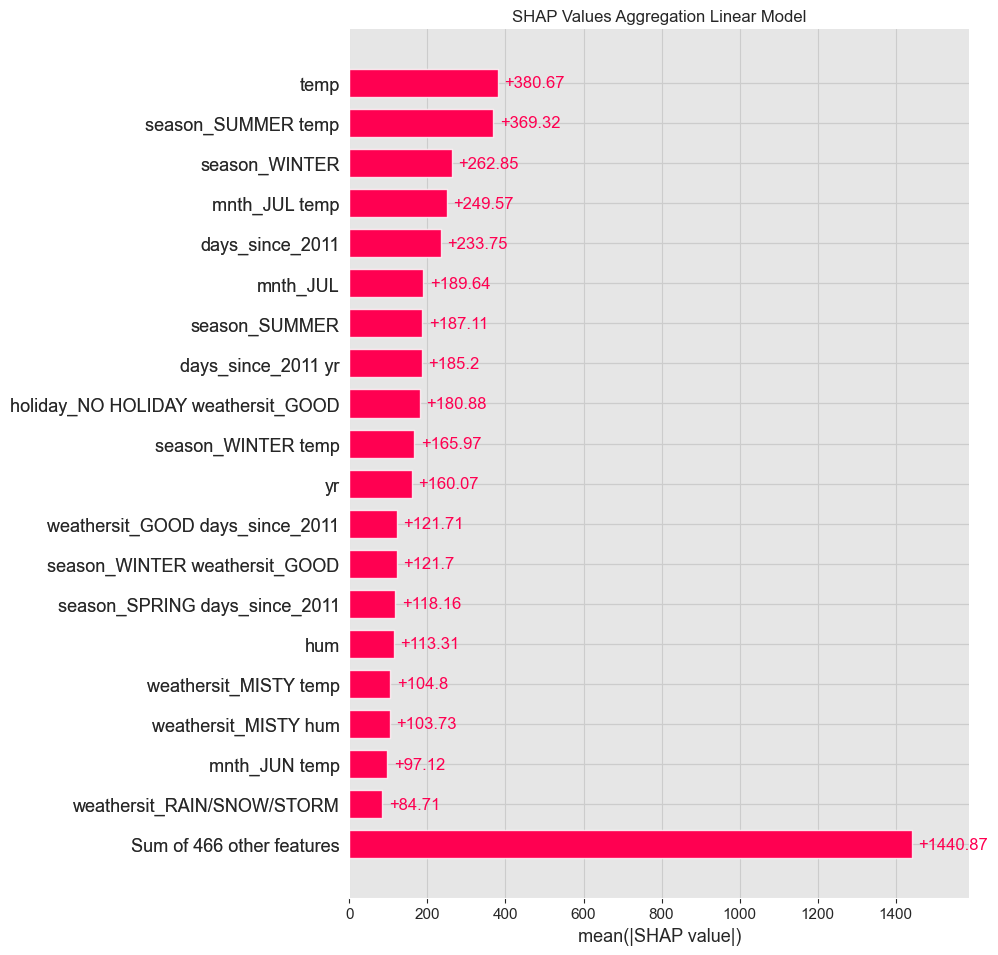

In [54]:
shap.plots.bar(shap_values=linear_shap_values, max_display=20, show=False)
plt.title('SHAP Values Aggregation Linear Model');

Here are some remarks on the results:
- `temp mnth_JUL` interaction term is the one with highest SHAP values. This feature has the largest $\beta$ coefficient in absolute value. 
- The feature `weathersit_RAIN/SNOW/STORM` has a large beta coefficient (absolute value), but it is not on the top SHAP features.
- The SHAP values ranking is similar to the one obtained using permutation importance.

Let us now plot the SHAP values for  as a function of `temp`:

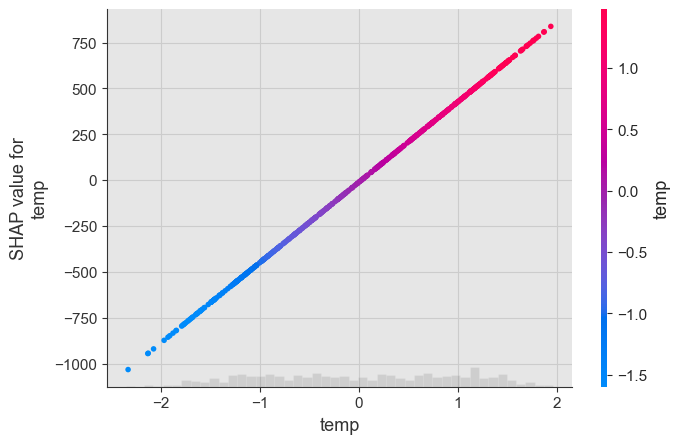

In [55]:
idx_1 = np.argwhere(np.array(linear_features) == 'temp')[0][0]

shap.plots.scatter(
    shap_values=linear_shap_values[:, idx_1],
    color=linear_shap_values[:, idx_1]
)

The plot is very similar to the weight effect plot above except we have now the scaled `tmp` on the x-axis. Note that this line passes through the origin (as expected).

We can also plot the explanation for an individual data instance. For example:

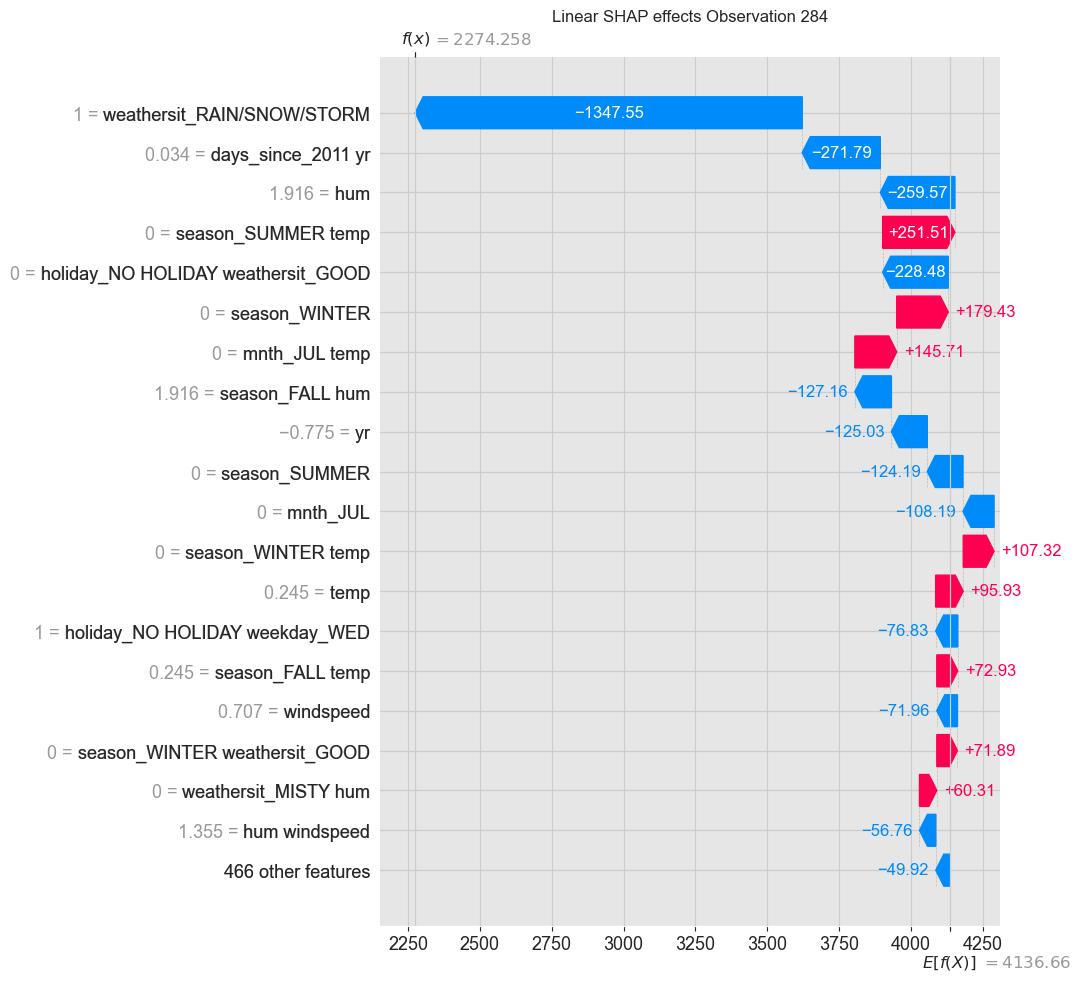

In [56]:
shap.plots.waterfall(
    shap_values=linear_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index}');

Note that the top negative features are `weathersit_RAIN/SNOW/STORM` and `hum` as in the weight effect plot for the linear model above. Note however that the top positive feature is `mnth_JUL temp`, which is quite strange as the data instance is from `mnth=OKT`. Here is a way to get just the features with non-zero entries:

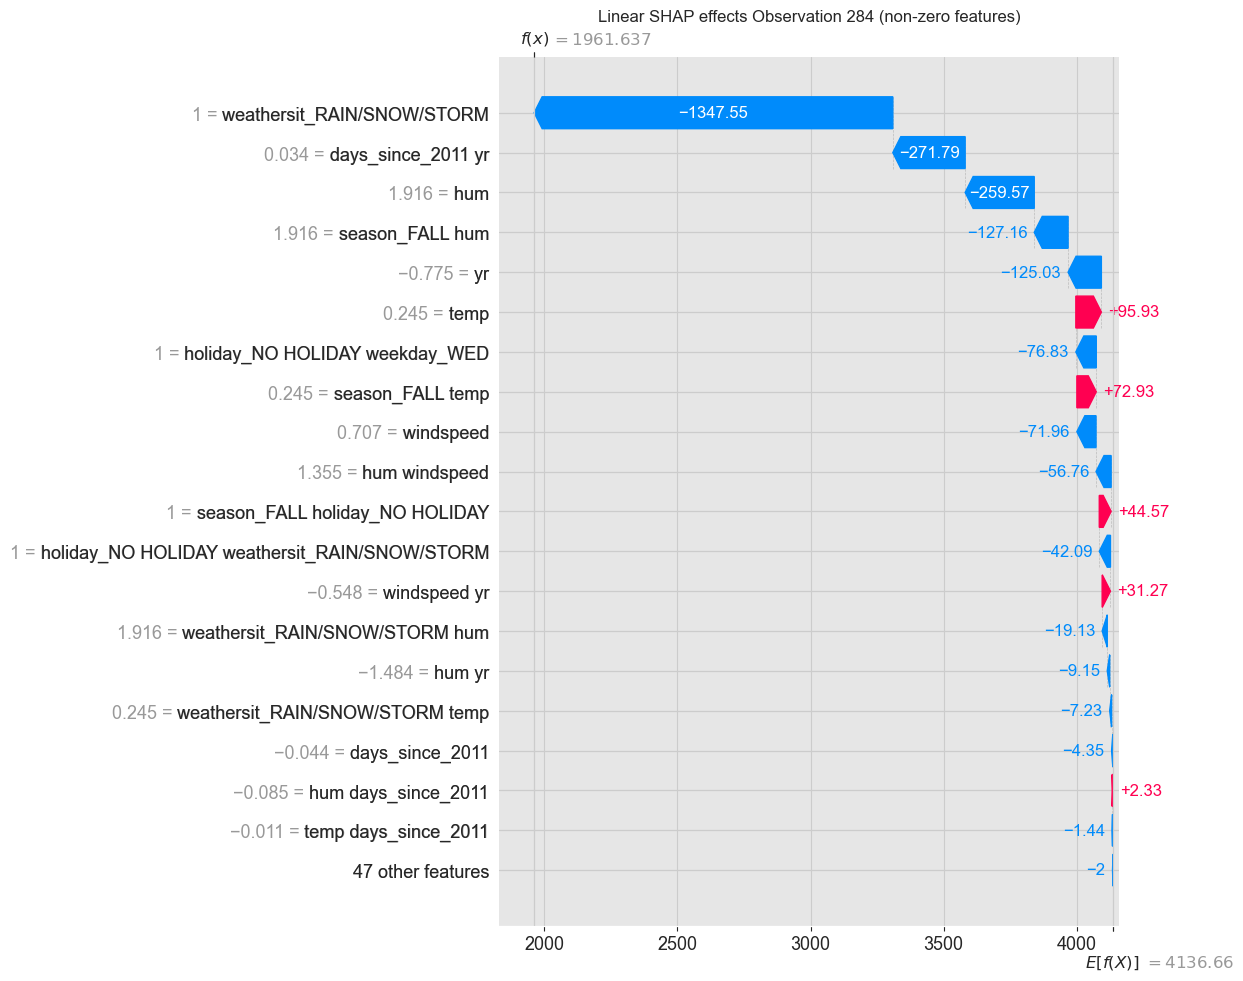

In [57]:
from shap._explanation import Explanation

mask = linear_shap_values[obs_index].data != 0
linear_shap_values_mask = linear_shap_values[obs_index][mask]

explanation_mask = Explanation(
        values=linear_shap_values_mask.values, 
        base_values=linear_shap_values_mask.base_values,
        data=linear_shap_values_mask.data,
        feature_names=np.array(linear_shap_values[obs_index].feature_names)[mask]
    )

shap.plots.waterfall(
    shap_values=explanation_mask,
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index} (non-zero features)');

### Tree Model

We can proceed similarly for the tree model:

In [58]:
tree_shap_explainer = shap.TreeExplainer(
    model=tree_grid_search.best_estimator_['tree_regressor'],
    masker=shap.maskers.Independent(data=tree_x_train, max_samples=500)

)

tree_shap_values = tree_shap_explainer(tree_x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


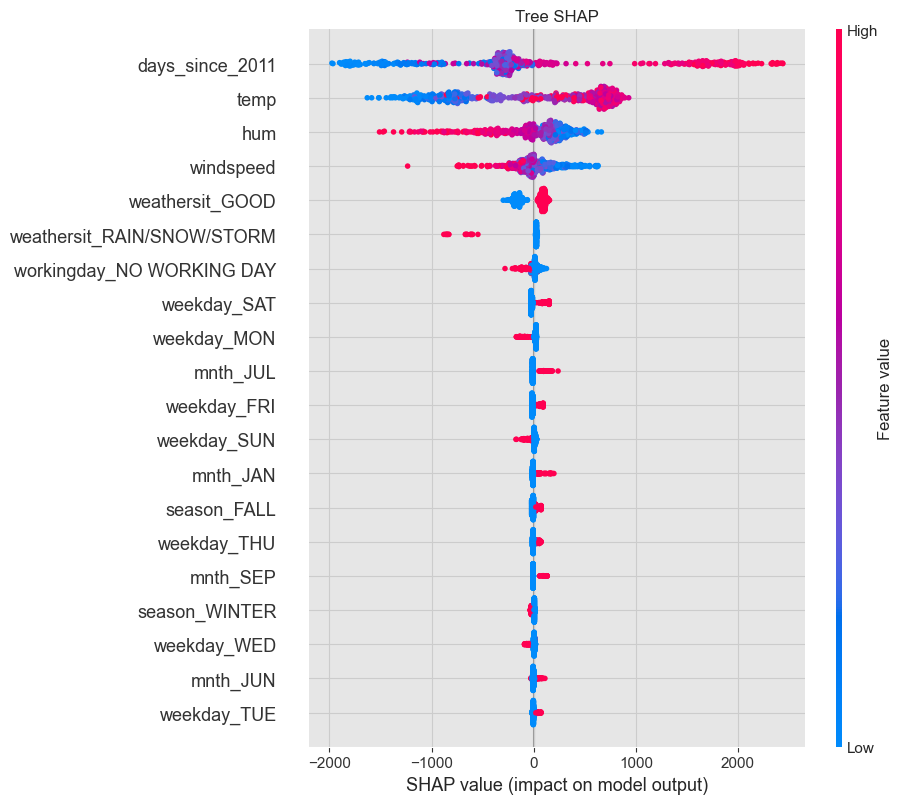

In [59]:
shap.summary_plot(
    shap_values=tree_shap_values,
    features=tree_x_train,
    show=False
)
plt.title(f'Tree SHAP');

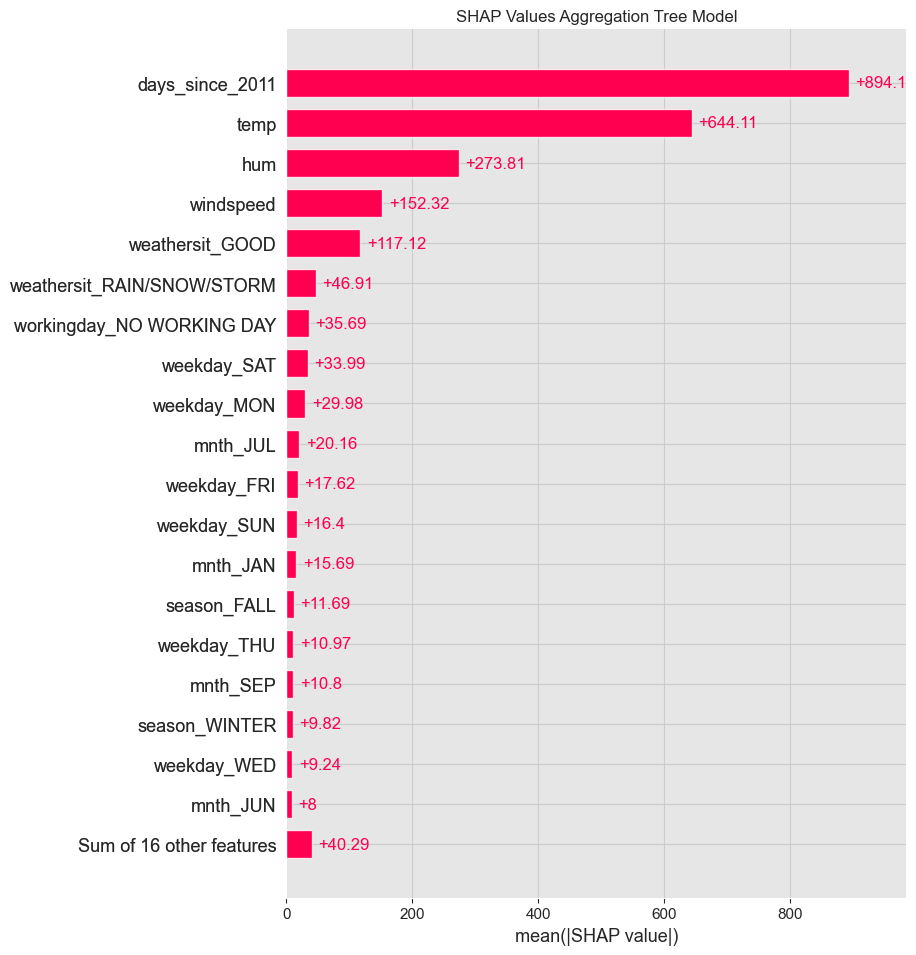

In [60]:
shap.plots.bar(
    shap_values=tree_shap_values,
    max_display=20,
    show=False
)
plt.title('SHAP Values Aggregation Tree Model');

Here are some remarks on the results:
- The SHAP ranking looks quite similar to the tree-native feature importance metrics.
- Similarly, this SHAP ranking is quite similar to the one obtained via permutation importance.

Let us now plot the SAHP values as a function of `temp` and `hum`.

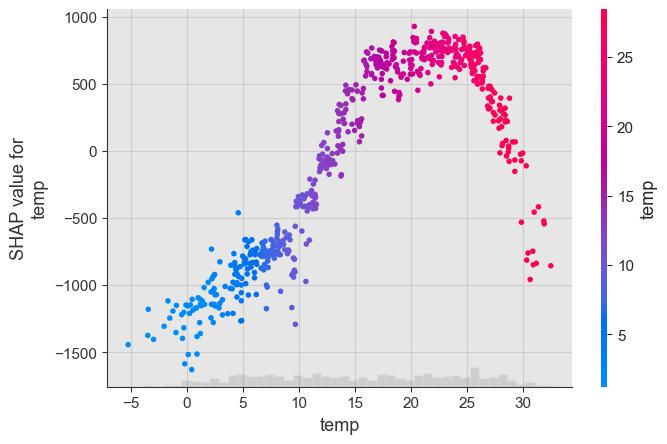

In [61]:
idx_1 = np.argwhere(np.array(features_ext) == 'temp')[0][0]

shap.plots.scatter(
    shap_values=tree_shap_values[:, idx_1],
    color=tree_shap_values[:, idx_1]
)

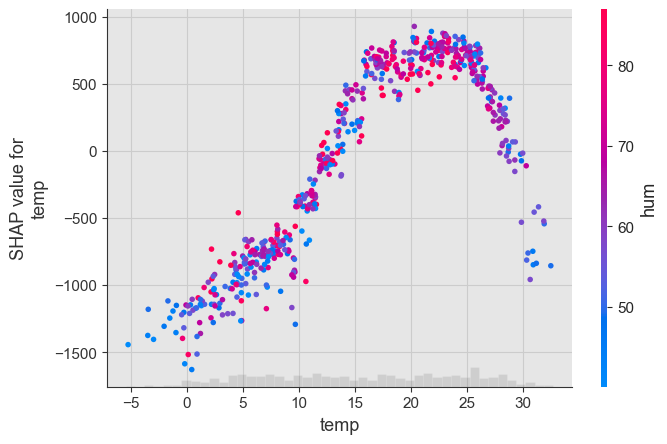

In [62]:
idx_1 = np.argwhere(np.array(features_ext) == 'temp')[0][0]
idx_2 = np.argwhere(np.array(features_ext) == 'hum')[0][0]

shap.plots.scatter(
    shap_values=tree_shap_values[:, idx_1],
    color=tree_shap_values[:, idx_2]
)

This plot looks quite similar to the PDP above. 

Now let us take a look into the SHAP explanation for the single data instance:

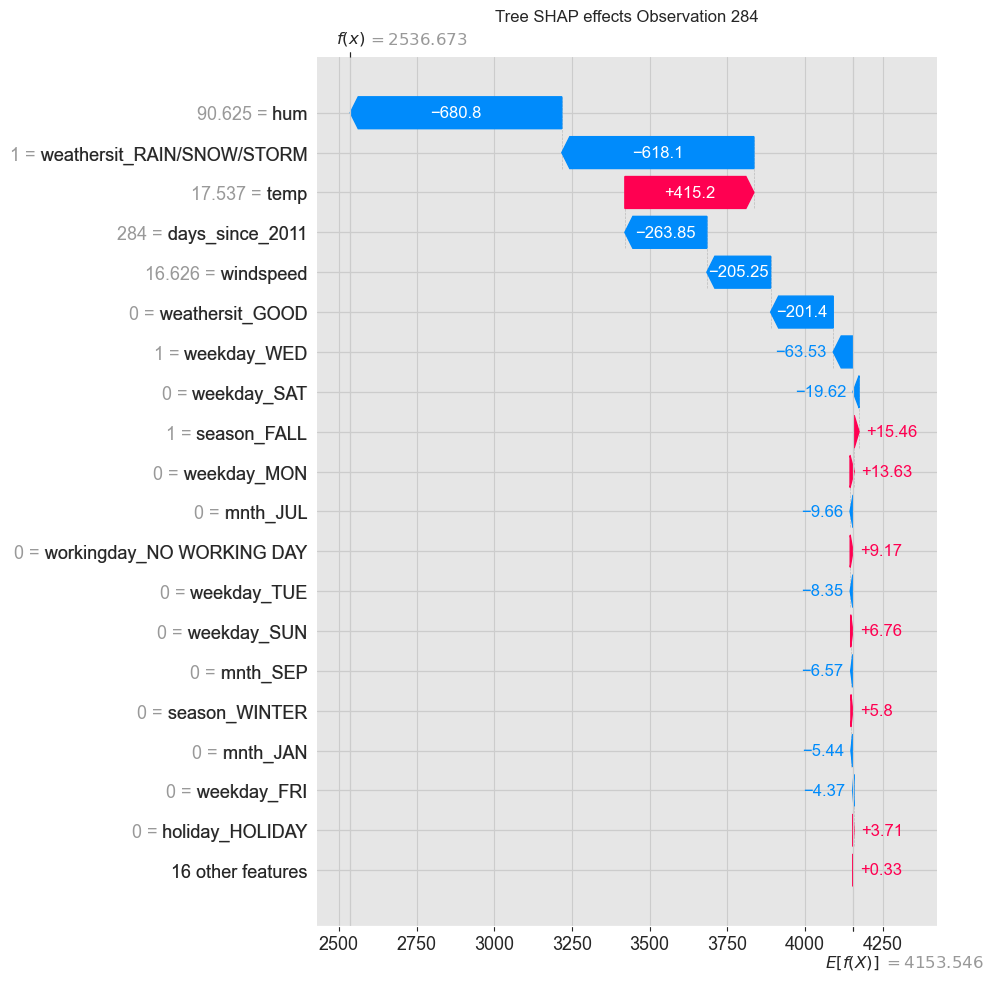

In [63]:
shap.plots.waterfall(
    shap_values=tree_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Tree SHAP effects Observation {obs_index}');

The explanation looks very similar to the linear model: `weathersit_RAIN/SNOW/STORM`, `hum`, `days_since_2011` and `windspeed` the highest negative weight effects and `temp` the main positive weight effect.

There are many other plots available, see [SHAP documentation](https://shap.readthedocs.io/en/latest/api_examples.html#plots).